# CIS 545 Project: ED-Admission Prediction

## Authors: Eric Cho, Krystal Ma, Christopher Snider

# Background

**Data Source**

The data source for this project is the Yale Hospital triage and patient history dataset (available at https://github.com/yaleemmlc/admissionprediction). The dataset includes over 560,000 emergency department (ED) visits at 3 sites from March 2014 through July 2017. We randomly sampled 50,000 records from this dataset. There are 972 columns in the data, which include features covering the patient’s condition when presenting to the ED, previous labs, medications, and medical history. The label of interest indicates whether the patient was admitted to the hospital or discharged from the ED.

**Objective**

We intend to leverage the dataset to predict hospital admission at the time of ED triage using patient history in addition to information collected at triage. Prediction models in medicine seek to improve patient care and increase logistical efficiency, early identification of ED patients who are likely to require admission may enable better optimization of hospital resources through improved understanding of ED patient mixtures. Besides predictive analysis, we are also interested in exploring different features’ importance in predicting the class label to see if we could find any related ethical problems. For example, if the hospital’s decision on admitting the patient could largely be impacted by the patient’s race, or income. 

Since the problem is a classification problem, we are planning to use logistic regression and/or random forest as machine learning baseline. These two models should give us a fairly confident idea on how accurate our models can achieve. After we obtain a baseline, we can develop a neural network model to examine whether deep learning gives us a better result. We will also tune the hyperparameters to improve the performance of the model.

**Primary Aim**

After building the model, we will evaluate its overall performance as well as its performance within subgroups. The authors of the original dataset and related publication (Hong, Haimovich, & Taylor, 2018) had included patient demographics, such as race, ethnicity, language, and religion in their model. Even when excluding sensitive patient characteristics from the model, less readily apparent features may still have associations with these characteristics, leading to bias by proxy. For instance, the patient's acuity level in the ED is a strong predictor of admission, but is determined by the clinician and not completely objective. Racial differences in this score have been observed even after adjusting for other demographic and clinical characteristics (Schrader & Lewis, 2013). Not adequately considering these potential biases could lead to differential performance of the model among subgroups, which may delay access to care and ultimately exacerbate health disparities if applied in the real world. 

# Load Libraries

In [46]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import warnings
import torch

#!pip install tableone
from tableone import TableOne
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix


In [47]:
# Functions

def roc_plot(y, preds):
  roc_auc = roc_auc_score(y, preds[:,1])
  fpr, tpr, thresholds = roc_curve(y, preds[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('ROC')
  plt.show()


# Data Preparation

## Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [49]:
# Load Data from Shared Drive

tfr = pd.read_csv('/content/drive/Shareddrives/CIS545Project/ED_Triage_50k.csv', chunksize=1000)
ed = pd.concat(tfr, ignore_index=True)

## Clean Data

In [50]:
# Let's take a look at our dataset.

pd.set_option('display.max_columns', None)

ed.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,arrivalmonth,arrivalday,arrivalhour_bin,previousdispo,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,acutphanm,adjustmentdisorders,adltrespfl,alcoholrelateddisorders,allergy,amniosdx,analrectal,anemia,aneurysm,anxietydisorders,appendicitis,artembolism,asppneumon,asthma,attentiondeficitconductdisruptivebeha,backproblem,biliarydx,birthasphyx,birthtrauma,bladdercncr,blindness,bnignutneo,bonectcncr,bph,brainnscan,breastcancr,breastdx,brnchlngca,bronchitis,burns,cardiaarrst,cardiacanom,carditis,cataract,cervixcancr,chestpain,chfnonhp,chrkidneydisease,coaghemrdx,coloncancer,comabrndmg,complicdevi,complicproc,conduction,contraceptiv,copd,coronathero,crushinjury,cysticfibro,deliriumdementiaamnesticothercognitiv,developmentaldisorders,diabmelnoc,diabmelwcm,disordersusuallydiagnosedininfancych,diverticulos,dizziness,dminpreg,dysrhythmia,earlylabor,ecodesadverseeffectsofmedicalcare,ecodesadverseeffectsofmedicaldrugs,ecodescutpierce,ecodesdrowningsubmersion,ecodesfall,ecodesfirearm,ecodesfireburn,ecodesmachinery,ecodesmotorvehicletrafficmvt,ecodesnaturalenvironment,ecodesotherspecifiedandclassifiable,ecodesotherspecifiednec,ecodespedalcyclistnotmvt,ecodesplaceofoccurrence,ecodespoisoning,ecodesstruckbyagainst,ecodessuffocation,ecodestransportnotmvt,ecodesunspecified,ectopicpreg,encephalitis,endometrios,epilepsycnv,esophcancer,esophgealdx,exameval,eyeinfectn,fatigue,femgenitca,feminfertil,fetaldistrs,fluidelcdx,fuo,fxarm,fxhip,fxleg,fxskullfac,gangrene,gasduoulcer,gastritis,gastroent,giconganom,gihemorrhag,giperitcan,glaucoma,goutotcrys,guconganom,hdnckcancr,headachemig,hemmorhoids,hemorrpreg,hepatitis,hivinfectn,hodgkinsds,hrtvalvedx,htn,htncomplicn,htninpreg,hyperlipidem,immunitydx,immunizscrn,impulsecontroldisordersnec,inducabortn,infectarth,influenza,infmalegen,intestinfct,intobstruct,intracrninj,jointinjury,kidnyrnlca,lateeffcvd,leukemias,liveborn,liveribdca,longpregncy,lowbirthwt,lungexternl,lymphenlarg,maintchemr,malgenitca,maligneopls,malposition,meningitis,menopausldx,menstrualdx,miscellaneousmentalhealthdisorders,mooddisorders,mouthdx,ms,multmyeloma,mycoses,nauseavomit,neoplsmunsp,nephritis,nervcongan,nonepithca,nonhodglym,nutritdefic,obrelatedperintrauma,opnwndextr,opnwndhead,osteoarthros,osteoporosis,otacqdefor,otaftercare,otbnignneo,otbonedx,otcirculdx,otcomplbir,otconganom,otconntiss,otdxbladdr,otdxkidney,otdxstomch,otendodsor,otfemalgen,othbactinf,othcnsinfx,othematldx,othercvd,othereardx,otheredcns,othereyedx,othergidx,othergudx,otherinjury,otherpregnancyanddeliveryincludingnormal,otherscreen,othfracture,othheartdx,othinfectns,othliverdx,othlowresp,othmalegen,othnervdx,othskindx,othveindx,otinflskin,otitismedia,otjointdx,otnutritdx,otperintdx,otpregcomp,otprimryca,otrespirca,otupprresp,otuprspin,ovariancyst,ovarycancer,pancreascan,pancreasdx,paralysis,parkinsons,pathologfx,pelvicobstr,perintjaund,peripathero,peritonitis,personalitydisorders,phlebitis,pid,pleurisy,pneumonia,poisnnonmed,poisnotmed,poisonpsych,precereoccl,prevcsectn,prolapse,prostatecan,pulmhartdx,rctmanusca,rehab,respdistres,retinaldx,rheumarth,schizophreniaandotherpsychoticdisorde,screeningandhistoryofmentalhealthan,septicemia,septicemiaexceptinlabor,sexualinfxs,shock,sicklecell,skininfectn,skinmelanom,sle,socialadmin,spincorinj,spontabortn,sprain,stomchcancr,substancerelateddisorders,suicideandintentionalselfinflictedin,superficinj,syncope,teethdx,testiscancr,thyroidcncr,thyroiddsor,tia,tonsillitis,tuberculosis,ulceratcol,ulcerskin,umbilcord,unclassified,urinstone,urinyorgca,uteruscancr,uti,varicosevn,viralinfect,whtblooddx,n_edvisits,n_admissions,absolutelymphocytecount_last,acetonebld_last,alanineaminotransferase(alt)_last,albumin_last,alkphos_last,anc(absneutrophilcount)_last,aniongap_last,aspartateaminotransferase(ast)_last,"b-typenatriureticpeptide,pro(probnp)_last",baseexcess(poc)_last,"baseex

In [51]:
ed.columns.to_list()

# Check for columns with missing values
ed.isna().sum().sort_values(ascending=False).head(20)

# ed.columns.to_list()
# ed.info()

phencyclidine(pcp)screen,urine,noconf._last      50000
phencyclidine(pcp)screen,urine,noconf._max       50000
epithelialcells_min                              50000
phencyclidine(pcp)screen,urine,noconf._median    50000
epithelialcells_median                           50000
phencyclidine(pcp)screen,urine,noconf._min       50000
epithelialcells_max                              50000
epithelialcells_last                             50000
benzodiazepinesscreen,urine,noconf._last         50000
benzodiazepinesscreen,urine,noconf._max          49997
benzodiazepinesscreen,urine,noconf._min          49997
benzodiazepinesscreen,urine,noconf._median       49997
acetonebld_last                                  49955
poctroponini._last                               49922
acetonebld_median                                49780
acetonebld_min                                   49780
acetonebld_max                                   49780
poctroponini._min                                49611
poctroponi

In [55]:
# View Column Indexes
[(ed.columns.get_loc(col),col) for col in ed.columns][0:30]

[(0, 'dep_name'),
 (1, 'esi'),
 (2, 'age'),
 (3, 'gender'),
 (4, 'ethnicity'),
 (5, 'race'),
 (6, 'lang'),
 (7, 'religion'),
 (8, 'maritalstatus'),
 (9, 'employstatus'),
 (10, 'insurance_status'),
 (11, 'disposition'),
 (12, 'arrivalmode'),
 (13, 'arrivalmonth'),
 (14, 'arrivalday'),
 (15, 'arrivalhour_bin'),
 (16, 'previousdispo'),
 (17, '2ndarymalig'),
 (18, 'abdomhernia'),
 (19, 'abdomnlpain'),
 (20, 'abortcompl'),
 (21, 'acqfootdef'),
 (22, 'acrenlfail'),
 (23, 'acutecvd'),
 (24, 'acutemi'),
 (25, 'acutphanm'),
 (26, 'adjustmentdisorders'),
 (27, 'adltrespfl'),
 (28, 'alcoholrelateddisorders'),
 (29, 'allergy')]

In [56]:
# Copy Dataset
clean = ed.copy()

# Create a binary variable for label of interest
clean['admit_yn'] = np.where(clean.disposition=='Admit',1,0)

# Create variables indicating prescence of chief complaints, labs, medical history, medications, vitals
clean['any_chief_complaints_yn'] = np.where(clean.iloc[:,772:972].fillna(0).max(axis=1)>=1,1,0)

clean['any_esi_yn'] = clean['esi'].notnull().astype('int')

# Some labs are stored as zeros, so we check for any non-zero values
clean['any_labs_yn'] = np.where(clean.iloc[:,300:679].fillna(0).max(axis=1)>=1,1,0)

clean['any_medical_hx_yn'] = clean.iloc[:,17:298].max(axis=1)

clean['any_medication_yn'] = np.where(clean.iloc[:,723:771].max(axis=1)>=1,1,0)

clean['any_vitals_yn'] = clean.iloc[:,679:714].notnull().max(axis=1).astype('int')

# Create New Categories for Small Counts
clean['race_category'] = np.where(clean.race.isin(['Native Hawaiian or Other Pacific Islander','Asian']),'Asian or Pacific Islander',
                               np.where(clean.race.isin(['Patient Refused','Unknown']),'Unknown',
                                        np.where(clean.race.isna(),'Unknown',clean.race)))

clean['religion_category'] = np.where(clean.religion.isin(['Catholic','Christian','Baptist','Pentecostal','Protestant','Episcopal','Methodist','Jehovah\'s Witness']),'Christian',clean.religion)

clean['previous_disposition_category'] = np.where(clean.previousdispo.isin(['LWBS after Triage','LWBS before Triage']),'LWBS',
                                               np.where(clean.previousdispo.isin(['LWBS after Triage','LWBS before Triage']),'LWBS',
                                                        np.where(clean.previousdispo.isin(['AMA','Eloped']),'AMA/Eloped',
                                                                 np.where(clean.previousdispo.isin(['Discharged']),'Discharged',
                                                                          np.where(clean.previousdispo.isin(['No previous dispo']),'No Previous Disposition',
                                                                                   np.where(clean.previousdispo.isin(['Admit']),'Admit','Other'))))))

clean['arrival_mode_category'] = np.where(clean.arrivalmode=='Car','Car',
                                               np.where(clean.arrivalmode=='ambulance','Ambulance',
                                                        np.where(clean.arrivalmode=='Walk-in','Walkin','Other')))

clean['employment_status_category'] = np.where(clean.employstatus=='Full Time','Full Time',
                                               np.where(clean.employstatus=='Not Employed','Not Employed',
                                                        np.where(clean.employstatus=='Retired','Retired',
                                                                 np.where(clean.employstatus=='Disabled','Disabled','Other'))))

clean['marital_status_category'] = np.where(clean.maritalstatus.isin(['Married','Life Partner','Civil Union','Significant Other']),'Married/with Partner',
                                               np.where(clean.maritalstatus.isin(['Divorced','Legally Separated']),'Divorced/Separated',
                                                        np.where(clean.maritalstatus=='Widowed','Widowed',
                                                                 np.where(clean.maritalstatus=='Single','Single','Other'))))
                                                                   

clean.drop(columns=['previousdispo','arrivalmode','race','religion','employstatus','maritalstatus'], inplace=True)



## Create Approximate Charlson Comorbidity Scores from Diagnoses in Medical History
The Charlson comorbidity score has been used as a predictor of mortality but can also be used as a representation of a patient's genernal health. We attempt to calculate the score here, however this only approximates the score because some of the CCS diagnosis categories in the data do not have sufficient specificity.

In [9]:
# Calculate Charlson Comorbidity Score from Medical History
# Exploring if it's possible to computer Charlson score from comorbidities but the codes they used might not be specific enough (e.g., paralysis includes monoplegia but CCI uses hemi/para)

clean['charlson'] = 0
# Acute Myocardial Infarction: 'acutemi'
clean['charlson'] = np.where(clean.acutemi==1,clean.charlson+1,clean.charlson)
# Congestive Heart Failure: 'chfnonhp'
clean['charlson'] = np.where(clean.chfnonhp==1,clean.charlson+1,clean.charlson)
# Peripheral Vascular Disease: 'peripathero'
clean['charlson'] = np.where(clean.peripathero==1,clean.charlson+1,clean.charlson)
# Cerebrovascular Disease: 'acutecvd', 'lateeffcvd', 'othercvd'
clean['charlson'] = np.where((clean.acutecvd==1) | (clean.lateeffcvd==1) | (clean.othercvd==1),clean.charlson+1,clean.charlson)
# Delirium Dementia: 'deliriumdementiaamnesticothercognitiv'
clean['charlson'] = np.where(clean.deliriumdementiaamnesticothercognitiv==1,clean.charlson+1,clean.charlson)
# COPD: 'copd'
clean['charlson'] = np.where(clean.copd==1,clean.charlson+1,clean.charlson)
# Rheumatoid Arthritis and Related Disease: 'rheumarth'
clean['charlson'] = np.where(clean.rheumarth==1,clean.charlson+1,clean.charlson)
# Gastroduodenal Ulcer: 'gasduoulcer'
clean['charlson'] = np.where(clean.gasduoulcer==1,clean.charlson+1,clean.charlson)
# Liver Disease: 'othliverdx'
clean['charlson'] = np.where(clean.othliverdx==1,clean.charlson+1,clean.charlson)
# Diabetes: 'diabmelnoc', 'diabmelwcm'
clean['charlson'] = np.where(clean.diabmelwcm==1,clean.charlson+2,
                             np.where(clean.diabmelnoc==1,clean.charlson+1,clean.charlson))
# Hemi/paraplegia: 'paralysis'
clean['charlson'] = np.where(clean.paralysis==1,clean.charlson+2,clean.charlson)
# Kidney Disease: 'chrkidneydisease'
clean['charlson'] = np.where(clean.chrkidneydisease==1,clean.charlson+2,clean.charlson)
# Lymphomas: 'hodgkinsds', 'nonhodglym'
clean['charlson'] = np.where((clean.hodgkinsds==1) | (clean.nonhodglym)==1,clean.charlson+2,clean.charlson)
# Leukemias: 'leukemias', 'multmyeloma'
clean['charlson'] = np.where((clean.leukemias==1) | (clean.multmyeloma==1),clean.charlson+2,clean.charlson)
# Any malignancy: 'bladdercncr', 'bonectcncr', 'breastcancr', 'brnchlngca', 'cervixcancr', 'coloncancer', 'esophcancer','hdnckcancr', 'kidnyrnlca', 'liveribdca', 'nonepithca', 'ovarycancer', 'pancreascan', 'stomchcancr', 'testiscancr','thyroidcncr', 'uteruscancr'
# Metastatic Cancer: '2ndarymalig'
clean['charlson'] = np.where(clean['2ndarymalig']==1,clean.charlson+6,
                             np.where((clean.bladdercncr==1) | (clean.bonectcncr==1) | (clean.breastcancr==1) | (clean.brnchlngca==1) | (clean.cervixcancr==1) | \
                                      (clean.coloncancer==1) | (clean.esophcancer==1) | (clean.hdnckcancr==1) | (clean.kidnyrnlca==1) | (clean.liveribdca==1) | \
                                      (clean.nonepithca==1) | (clean.ovarycancer==1) | (clean.pancreascan==1) | (clean.stomchcancr==1) | (clean.testiscancr==1) | \
                                      (clean.thyroidcncr==1) | (clean.uteruscancr==1),clean.charlson+2,clean.charlson))
# HIV/AIDS:  'hivinfectn'
clean['charlson'] = np.where(clean.hivinfectn==1,clean.charlson+6,clean.charlson)




## Create binary indicators (1/0) for the presence of individual lab and vitals measurements

Here we create indicator (1/0) variables for presence of lab data. Because many of the fields could be redundant (e.g., wbc_min, wbc_max, wbc_last), we only created an indicator for the "_last" entries.

In [10]:
# Apply 1/0 values to lab and vitals columns
lab_vitals_cols = clean.columns[294:382].append(clean.columns[646:655]).append(clean.columns[673:687]).to_list()

for col in lab_vitals_cols:
  clean[col+'_yn'] = clean[col].apply(lambda x: int(pd.notnull(x)))


# Exploratory Data Analysis

We have a very large dataset with many features. It's helpful see an overview of how the data is distributed based on different features. First, we plotted barcharts of our dataset based on its 15 categorical features. We then drilled down a bit in our analysis by exploring different relationships via more specific visualizations of different features (categorical and numeric). 

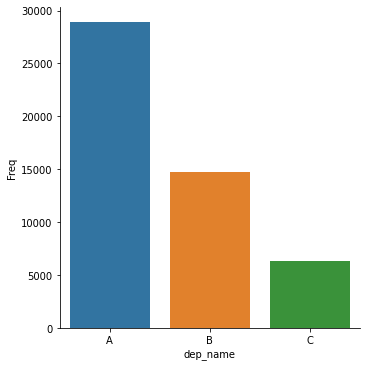

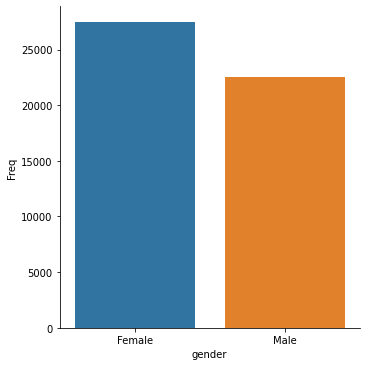

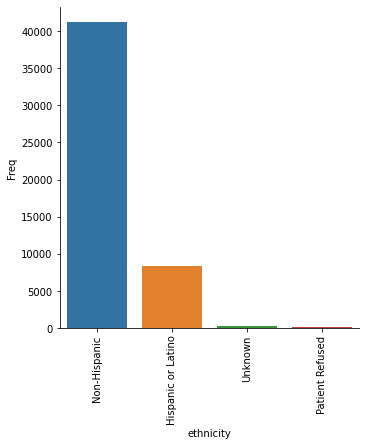

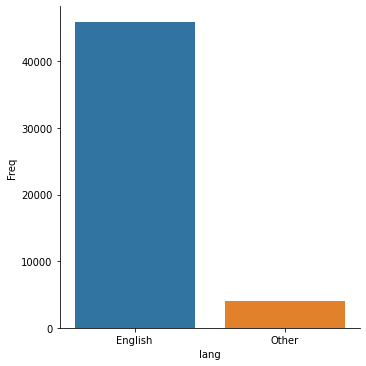

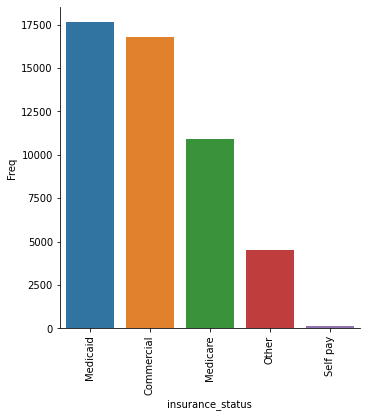

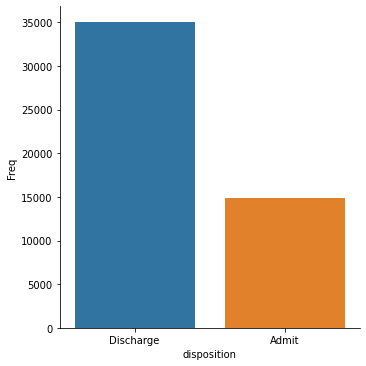

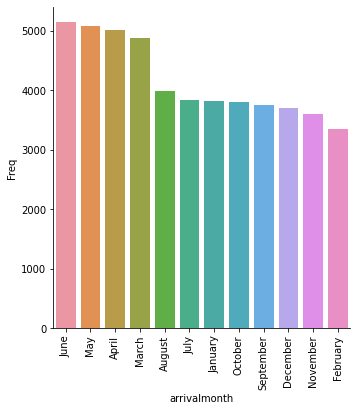

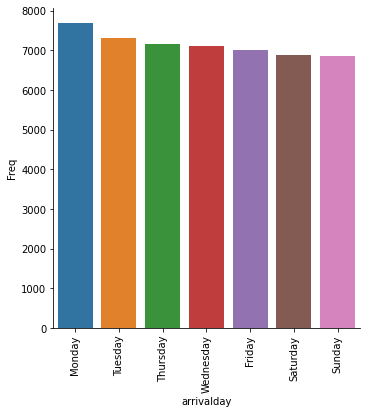

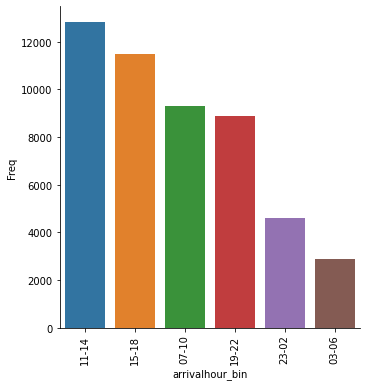

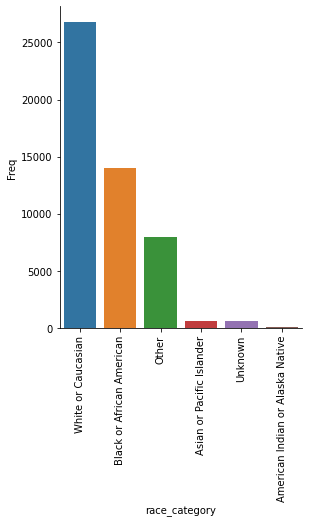

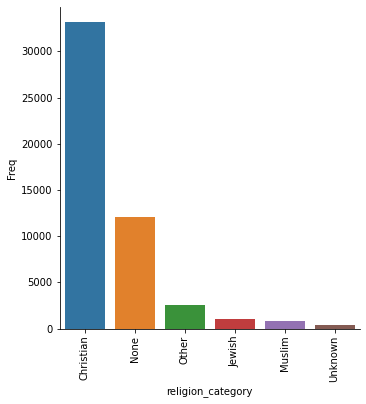

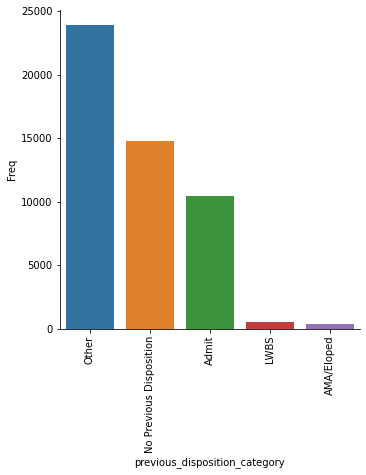

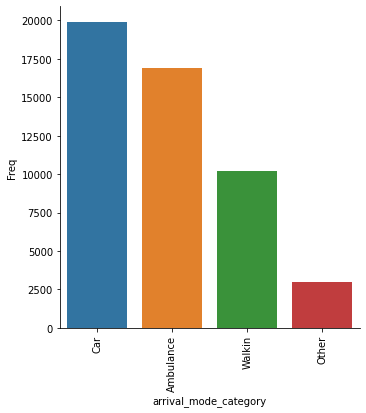

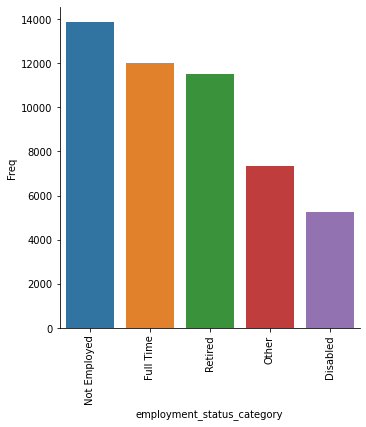

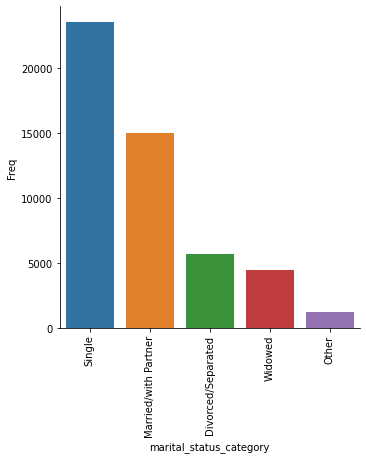

In [ ]:
# Overview of data Counts for categorical columns
categorical_columns = clean.columns[clean.dtypes==object]

for col in categorical_columns:
  sns.catplot(x=col, data=clean, kind='count', order=clean[col].value_counts().index)
  if len(clean[col].value_counts()) >= 4:
    plt.xticks(rotation=90)
  plt.ylabel('Freq')
  plt.show()


The boxplots below show us the breakdown of our dataset in terms of ESI and Age (two of our numeric features). It seems that there is a relatively symmetric distribution based on ESI and a right-skewed distribution based on age. More people under the age of around 60 seem to come to the emergency room. One could guess that this is due to there not being as many elderly people in the population to collect emergency department data from due to them already having care.

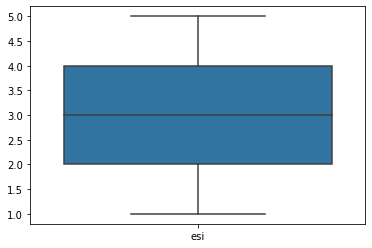

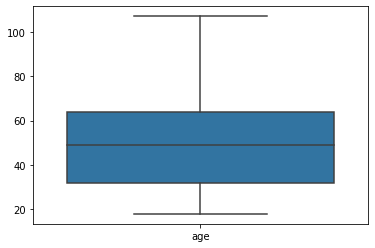

In [11]:
# Boxplots of the distribution based on Emergency Severity Index (ESI) and Age, both numeric features.

sns.boxplot(data=clean[['esi']])
plt.show()
sns.boxplot(data=clean[['age']])
plt.show()

Let's take a look at how certain features affect whether a person is actually admitted or discharged, starting with Emergency Severity Index (ESI). 

(bar plot)  <br>
There appears to be a relationship between ESI score and hospital admission, with and ESI score of 1 being the most urgent and 5 being the least urgent. An ESI score 4.0 or higher almost always results in discharge while a score of at least 3 had a good chance of being discharged. It's not surprising that a higher (close to 5) ESI score results in a patient being discharged more often than a lower one.

(correlation matrix) <br>
ESI and disposition appear to have a negative medium correlation, that is, as the ESI score rises
the admission rate decreases. It would make sense that the more severe a person's condition, the more likely they are to be admitted to the hospital.

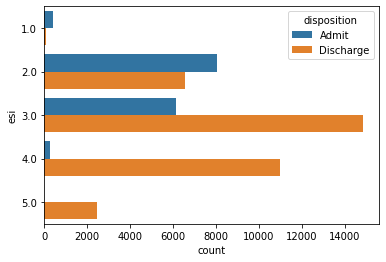

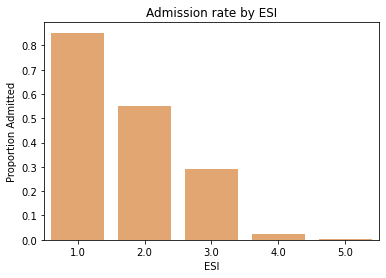

In [88]:
# barplot of hospital admission based by ESI score
sns.countplot(data=clean, y="esi", hue="disposition")
plt.show()

# Barplot of Admission Rate by ESI 
esi_df = clean.groupby('esi')['admit_yn'].mean().reset_index()

sns.barplot(x='esi', y='admit_yn', data=esi_df, color='sandybrown')
plt.title('Admission rate by ESI')
plt.ylabel('Proportion Admitted')
plt.xlabel('ESI')
plt.show()

In [ ]:
# correlation matrix
clean_eda = clean[['disposition']].apply(lambda x: {"Admit":1, "Discharge":0}[x.disposition], axis=1)
clean_eda = pd.DataFrame(clean_eda, columns=['disposition'])
clean_eda['esi'] = clean.esi
clean_eda.corr() 

,disposition,esi
disposition,1.000000,-0.442729
esi,-0.442729,1.000000


We are interested in carefully considering ethical repercussions of implementing a machine learning model that may affect who is admitted to a hospital after triage in the ED. Let's take a look at the distribution of the data by a person's ESI and race.  <br>
(bar plot) <br>
The plot shows that White or Caucasian patients represent a larger proportion of patients arriving with lower ESI (i.e., more severe), which we've seen is associated with higher rates of admission. It's important to note, however, that there are more data collected on White or Caucasian people than the other races (evident from cumulative bar size by race. It's important to measure this relationship directly to see whether race is associated with ESI acuity.<br>
(correlation matrix) <br>
From the correlation matrix, there does appear to be a slight negative correlation between White or Caucasian patients and the ESI, suggesting they tend to have a lower ESI compared to non-White patients.

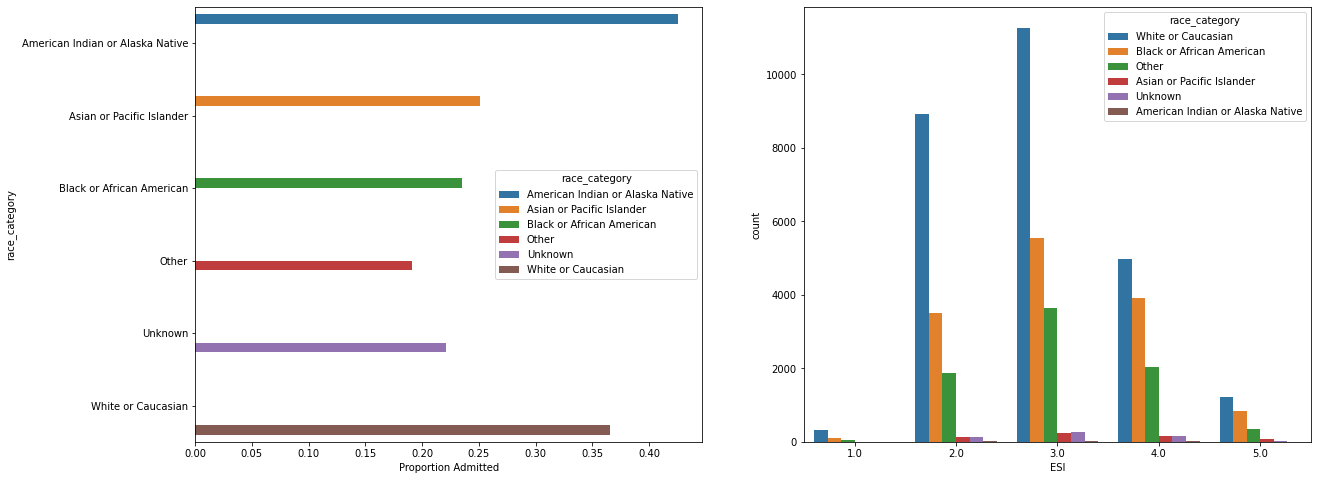

In [90]:
# barplot of distribution based on ESI and race
race_cat_df = clean.groupby('race_category')['admit_yn'].mean().reset_index()

fig,ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x='admit_yn', y='race_category', hue='race_category', data=race_cat_df, ax=ax[0])
sns.countplot(data=clean, x="esi", hue="race_category",ax=ax[1])
ax[0].set_xlabel('Proportion Admitted')
ax[1].set_xlabel('ESI')
plt.show()


In [ ]:
# correlation matrix

clean_eda = clean['race_category'].map({"White or Caucasian":1}).fillna(0)
clean_eda = pd.DataFrame(clean_eda, columns=['race_category'])
clean_eda['esi'] =  clean.esi
clean_eda.corr() 

,race_category,esi
race_category,1.00000,-0.11322
esi,-0.11322,1.00000


Could race play a role in whether someone is admitted to the hospital or not? <br>
(bar plot) <br>
The bar plot shows that a greater proportion of White or Caucasian individuals were admitted than those of other race categories. Let's see if is any association exists between race and the patient's disposition.<br>
(correlation matrix) <br>
The correlation matrix indicates a weak positive correlation between race and admission, suggesting White or Causian patients are slightly more likely to be admitted.

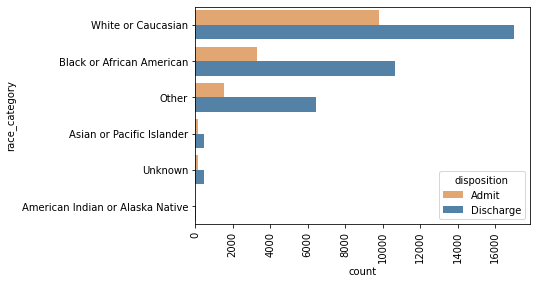

In [73]:
# bar plot of disposition based on race
pal = ['sandybrown','steelblue']
sns.countplot(data=clean, y='race_category', hue='disposition', palette = pal)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# correlation matrix

clean_eda_race = clean[['disposition']].apply(lambda x: {"Admit":1, "Discharge":0}[x.disposition], axis=1)
clean_eda_race = pd.DataFrame(clean_eda_race, columns=['disposition'])
clean_eda_race['race_category'] = clean['race_category'].map({"White or Caucasian":1}).fillna(0)
clean_eda_race.corr() 

,disposition,race_category
disposition,1.000000,0.158542
race_category,0.158542,1.000000


Below we visualize various other potentially interesting relationships in our dataset. 

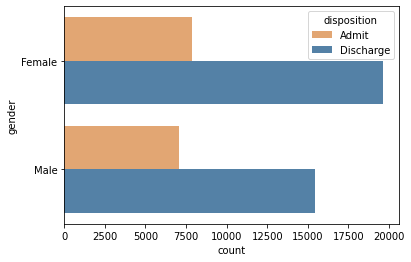

In [72]:
# There doesn't appear to be a clear relationship between gender and disposition. 

# bar plot of gender and disposition
pal = ['sandybrown','steelblue']
sns.countplot(data=clean, y="gender", hue="disposition", palette=pal)
plt.show()

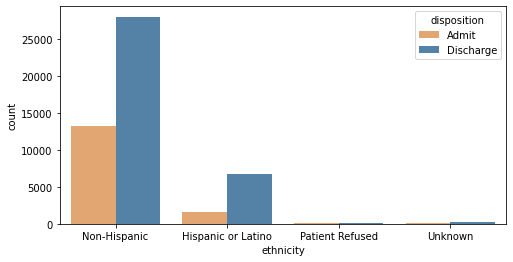

In [70]:
# It looks like a greater number of people non-Hispanics were admitted that discharged relative to their ethnic group. 

# bar plot of ethnicity and disposition
pal = ['sandybrown','steelblue']
fig,ax = plt.subplots(1,1, figsize=(8,4))
sns.countplot(data=clean, x="ethnicity", hue="disposition", palette=pal, ax=ax)
plt.show()

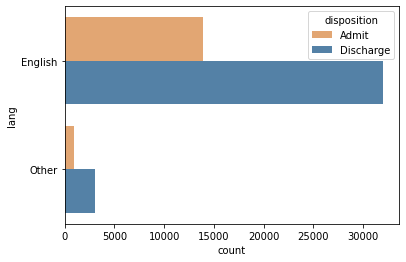

In [69]:
# Could language barriers play a role in disposition? 

pal = ['sandybrown','steelblue']
sns.countplot(data=clean, y="lang", hue="disposition", palette=pal)
plt.show()

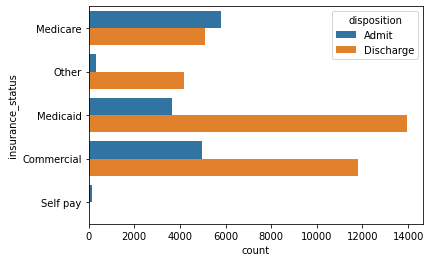

In [18]:
# Does one's insurance affect dispositon? It appears that only individuals on
# Medicare were more likely to be admitted than discharged. 

sns.countplot(data=clean, y="insurance_status", hue="disposition")
plt.show()

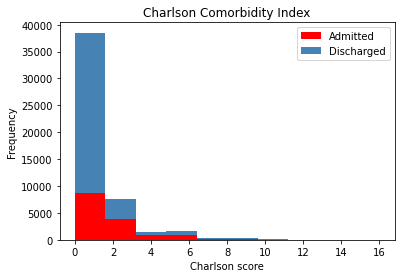

In [ ]:
# Histogram of Charlson Score
plt.figure()
plt.hist([clean[clean['admit_yn']==1].charlson,clean[clean['admit_yn']==0].charlson], color=['red','steelblue'], stacked=True)
plt.title('Charlson Comorbidity Index')
plt.xlabel('Charlson score')
plt.ylabel('Frequency')
plt.legend(['Admitted','Discharged'])
plt.show()

We used a correlation heatmap to visualize the labs and vitals data because we have so many different columns of them. Red squares indicate a strong positive correlation, blue squares negative correlations, and white squares indicate little or no correlation. There is evidence of some highly correlated labs and vitals, which in some cases may even be from the same test (e.g., spo2_max and spo2_min). Those would provide little information gain and might suggest the need for performing PCA.

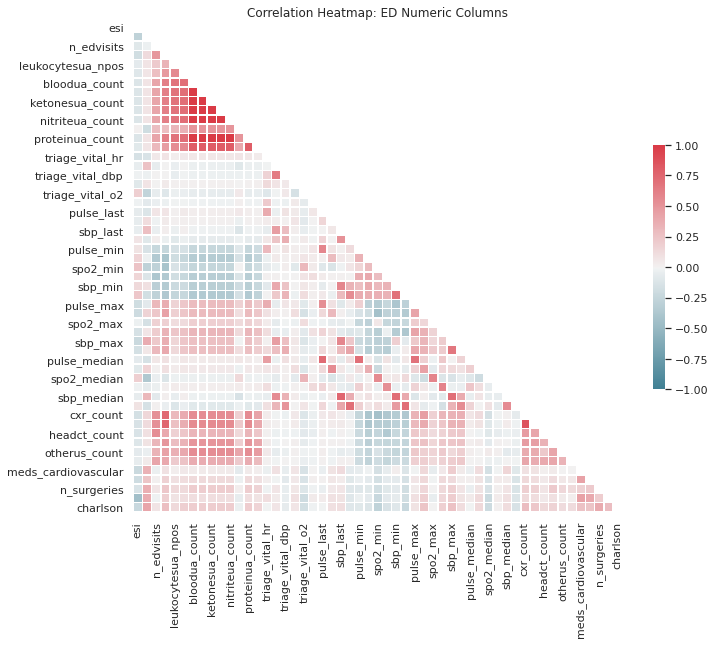

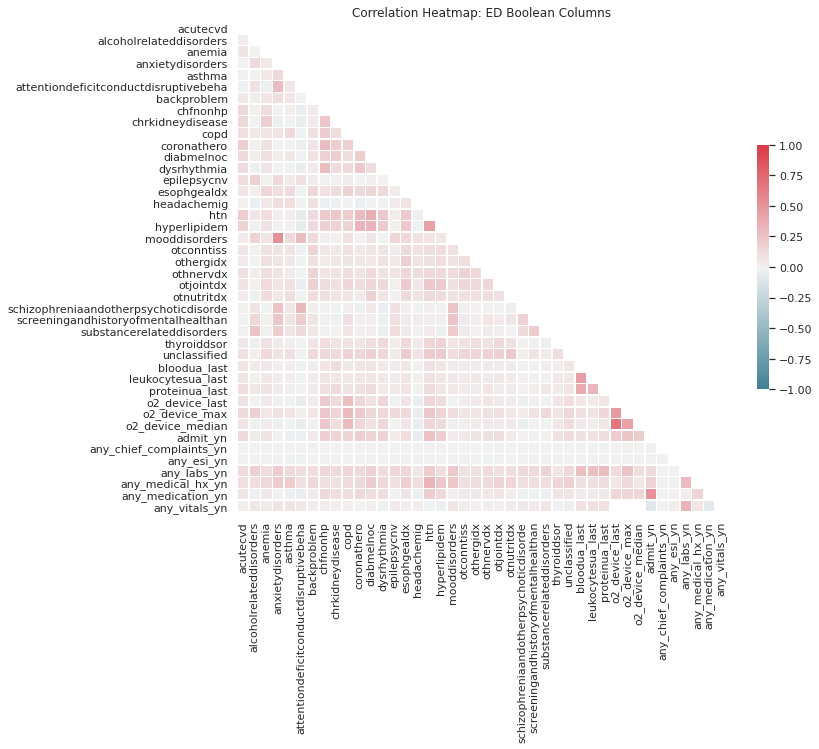

In [ ]:
# Identify numeric columns with lower missing rates 
numeric_columns = clean.columns[(clean.dtypes==float) | (clean.dtypes==int)][:965]
fin_numeric_columns = clean[numeric_columns].columns[((clean[numeric_columns].max(axis=0)>1) & (clean[numeric_columns].count(axis=0)>25000) & (clean[numeric_columns].mean(axis=0)>0.2)) | (clean[numeric_columns].columns=='admit_yn')]

# Calculated correlation matrix
correlation_matrix = clean[fin_numeric_columns].corr()

correlation_matrix

mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style = "white")

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap: ED Numeric Columns")
plt.show()

# Identify boolean columns with lower missing rates/high prevalence
bool_numeric_columns = clean[numeric_columns].columns[(clean[numeric_columns].max(axis=0)==1) & (clean[numeric_columns].count(axis=0)>20000) & (clean[numeric_columns].mean(axis=0)>0.05)]

# Calculated correlation matrix
correlation_matrix = clean[bool_numeric_columns].corr()

correlation_matrix

mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style = "white")

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap: ED Boolean Columns")
plt.show()


## Distributions

We visualize distributions for some of the continuous variables, including age, number of previous ED visits, and number of previous admissions.

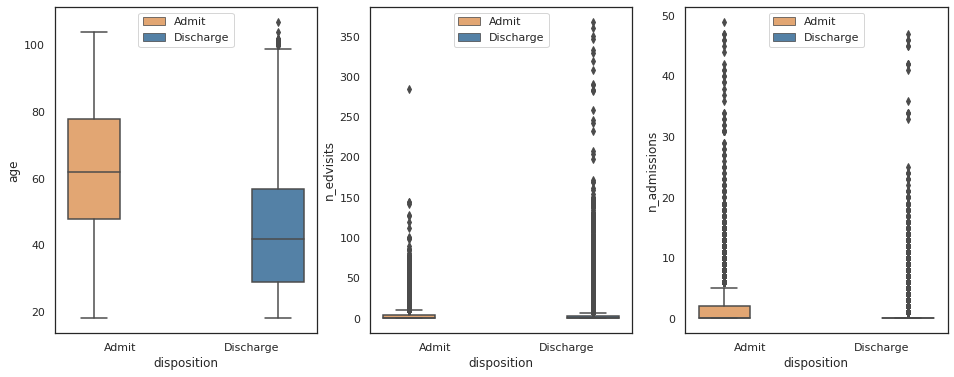

In [ ]:
# box plots of distributions for age

pal = ['sandybrown','steelblue']

fig, ax  = plt.subplots(1,3, figsize=(16,6))
sns.boxplot(x=clean['disposition'], y=clean['age'], hue=clean['disposition'], data=clean, ax=ax[0], palette=pal)
ax[0].legend(loc=9)
# plt.show()

# fig, ax  = plt.subplots(1,2, figsize=(12,6))
sns.boxplot(x=clean['disposition'], y=clean['n_edvisits'], hue=clean['disposition'], data=clean, ax=ax[1], palette=pal)
sns.boxplot(x=clean['disposition'], y=clean['n_admissions'], hue=clean['disposition'], data=clean, ax=ax[2], palette=pal)
ax[1].legend(loc=9)
ax[2].legend(loc=9)
plt.show()

The age distribution is bimodal and right-skewed for discharged patients, and slightly left-skewed for admitted patients (with a cut-off at age 18). Older patients are more likely to be admitted.

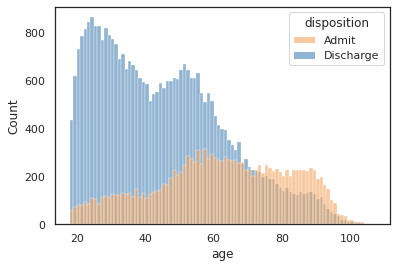

In [ ]:
# Age Distribution
pal = ['sandybrown','steelblue']

bin_range = clean['age'].max()-clean['age'].min()

sns.histplot(data=clean, x="age", bins=int(bin_range), hue='disposition', alpha=0.6, palette=pal)
plt.show()


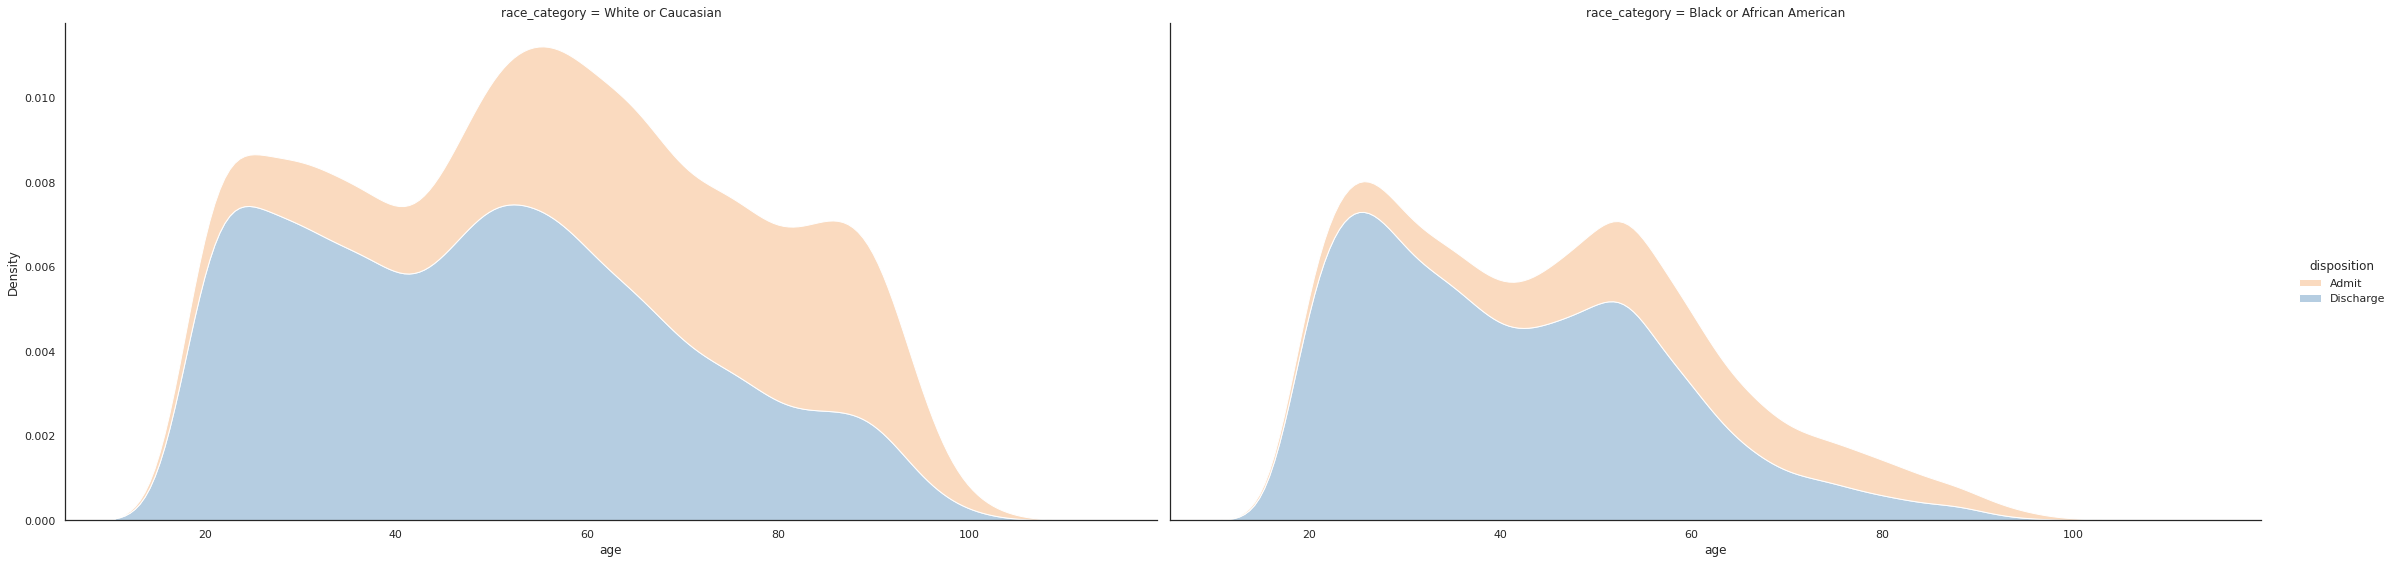

In [ ]:
# Age Distribution for White patients vs Black patients
sns.displot(data=clean[clean['race_category'].isin(['Black or African American','White or Caucasian'])], 
            x="age", hue="disposition", col='race_category', height=8, aspect=2, palette=pal, kind='kde', multiple='stack', alpha=0.4)
plt.show()

## Lab Data

Here we examine some summary data for specific labs. Some labs have very high missing rates, so it's difficult to determine whether the differences in mean lab results between admitted and discharged patients are meaningful.

In [ ]:
# Lab Columns 294-672
lab_cols = clean.columns[294:673]

lab_df = pd.DataFrame(columns = ['Lab', 'Total Entries', 'Missing', 'Admit Mean (SD)', 'Discharge Mean (SD)']) 
for col in lab_cols:
    col = col
    n_entries = clean[col].notnull().sum()
    n_missing = clean[col].isna().sum()
    value_admit = str(round(clean[clean['admit_yn']==1][col].mean(),2)) + ' (' + str(round(clean[clean['admit_yn']==1][col].std(),2)) + ')'
    value_discharge = str(round(clean[clean['admit_yn']==0][col].mean(),2)) + ' (' + str(round(clean[clean['admit_yn']==0][col].std(),2)) + ')'
    #print({'Feature':col, 'N (%)':value})
    lab_df = lab_df.append({'Lab':col, 'Total Entries':n_entries, 'Missing': n_missing, 'Admit Mean (SD)':value_admit, 'Discharge Mean (SD)':value_discharge}, ignore_index=True)
    
lab_df


,Lab,Total Entries,Missing,Admit Mean (SD),Discharge Mean (SD)
0,absolutelymphocytecount_last,19352,30648,1.75 (1.72),2.07 (2.69)
1,acetonebld_last,45,49955,9.48 (5.84),41.19 (65.76)
2,alanineaminotransferase(alt)_last,10987,39013,28.24 (45.73),27.8 (45.07)
3,albumin_last,9757,40243,3.79 (0.57),4.07 (0.46)
4,alkphos_last,11080,38920,103.71 (76.92),83.4 (43.41)
...,...,...,...,...,...
374,nitriteua_count,50000,0,0.95 (1.97),0.55 (1.51)
375,pregtestur_count,50000,0,0.26 (1.47),0.43 (1.59)
376,proteinua_count,50000,0,0.95 (1.97),0.55 (1.51)
377,"bloodculture,routine_count",50000,0,0.13 (0.57),0.04 (0.27)


## Triage Data

The following pairplots provide another way of looking at correlation among different variables. We visualize vitals at triage and other time points. Many demonstrate positive correlation, again suggesting PCA may be useful.

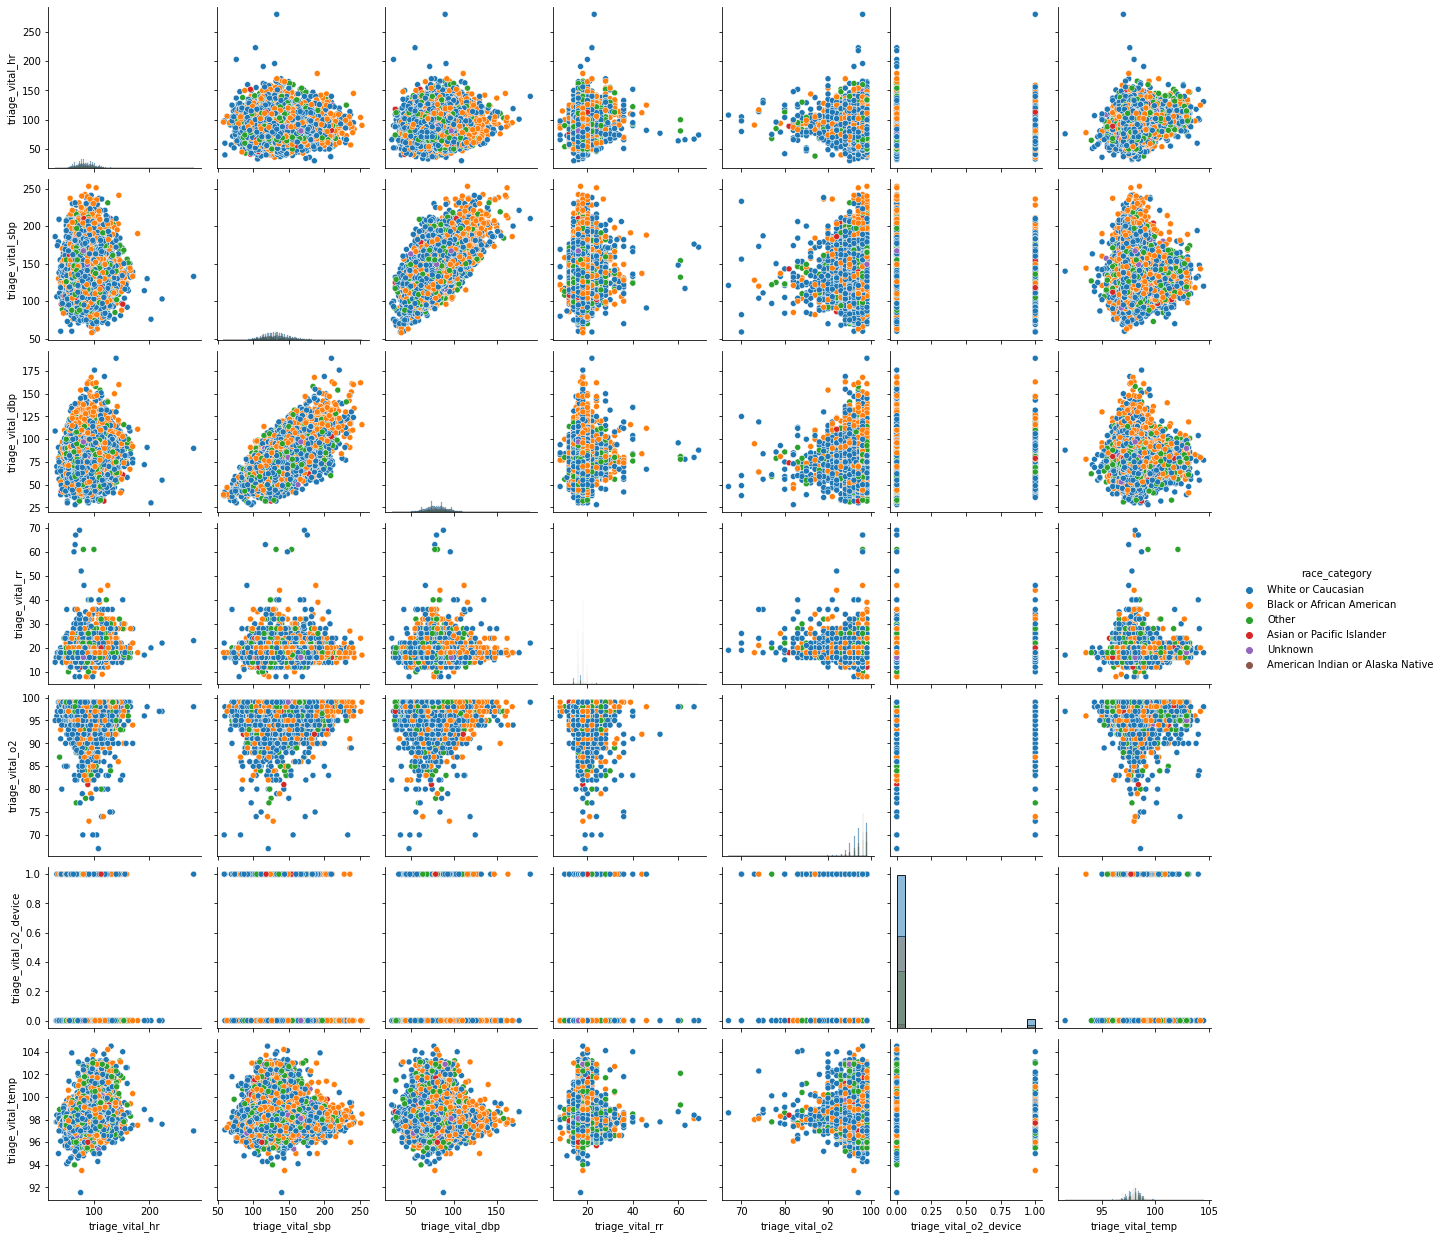

In [20]:
sns.pairplot(clean[['race_category','triage_vital_hr','triage_vital_sbp','triage_vital_dbp','triage_vital_rr','triage_vital_o2','triage_vital_o2_device','triage_vital_temp']], hue='race_category', diag_kind='hist')
plt.show()

In [21]:
 
sns.pairplot(clean[['disposition','pulse_last','sbp_last','dbp_last','pulse_min','sbp_min','dbp_min','pulse_max','sbp_max','dbp_max','pulse_median','sbp_median', 'dbp_median']], hue='disposition', diag_kind='auto')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

We also examine some of the missing data patterns for triage vitals. Admitted patients seem to have more missing data here.

Disposition: Admit


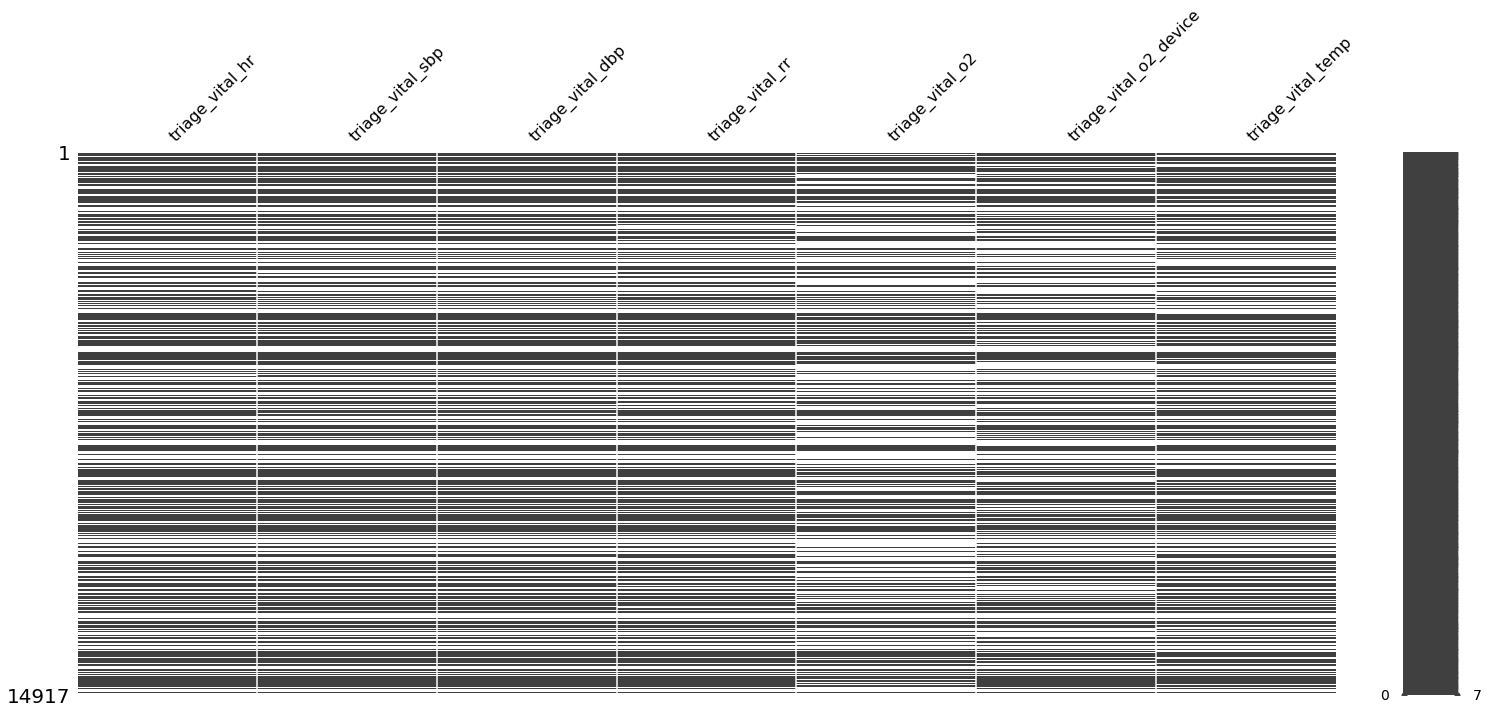

Disposition: Discharge


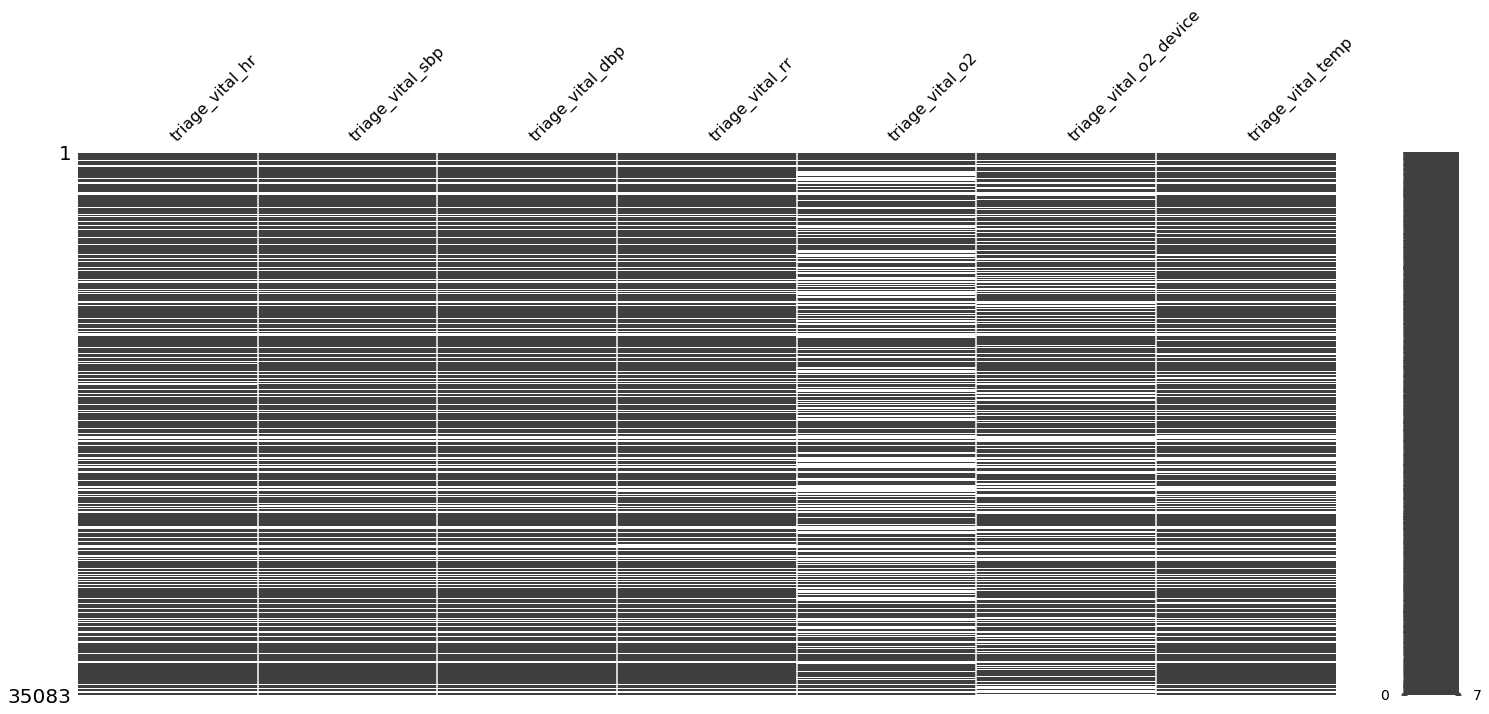

In [33]:
for disposition in clean.disposition.unique():
  df = clean[clean['disposition']==disposition]
  print('Disposition:',disposition)
  matrix = msno.matrix(df[['triage_vital_hr','triage_vital_sbp','triage_vital_dbp','triage_vital_rr','triage_vital_o2','triage_vital_o2_device','triage_vital_temp']])
  display(matrix)
  plt.show()


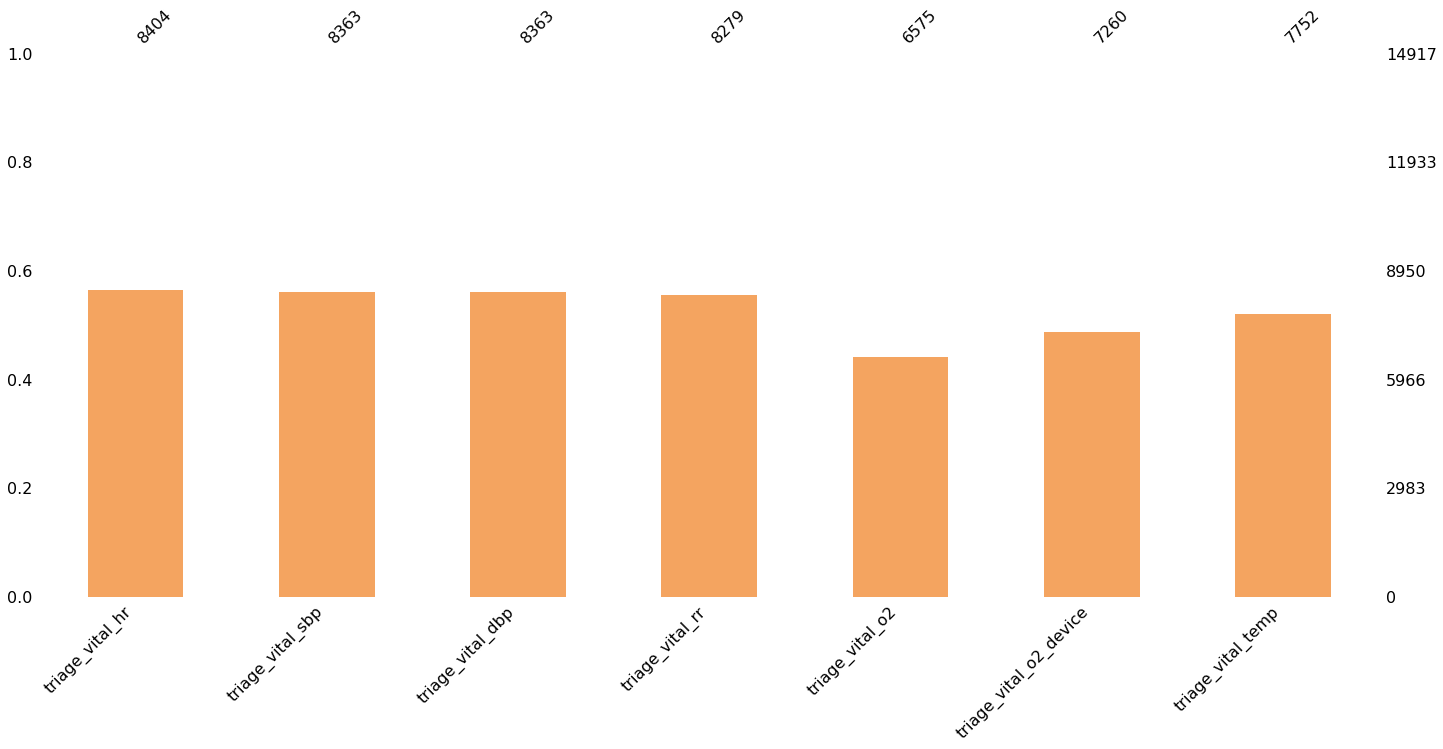

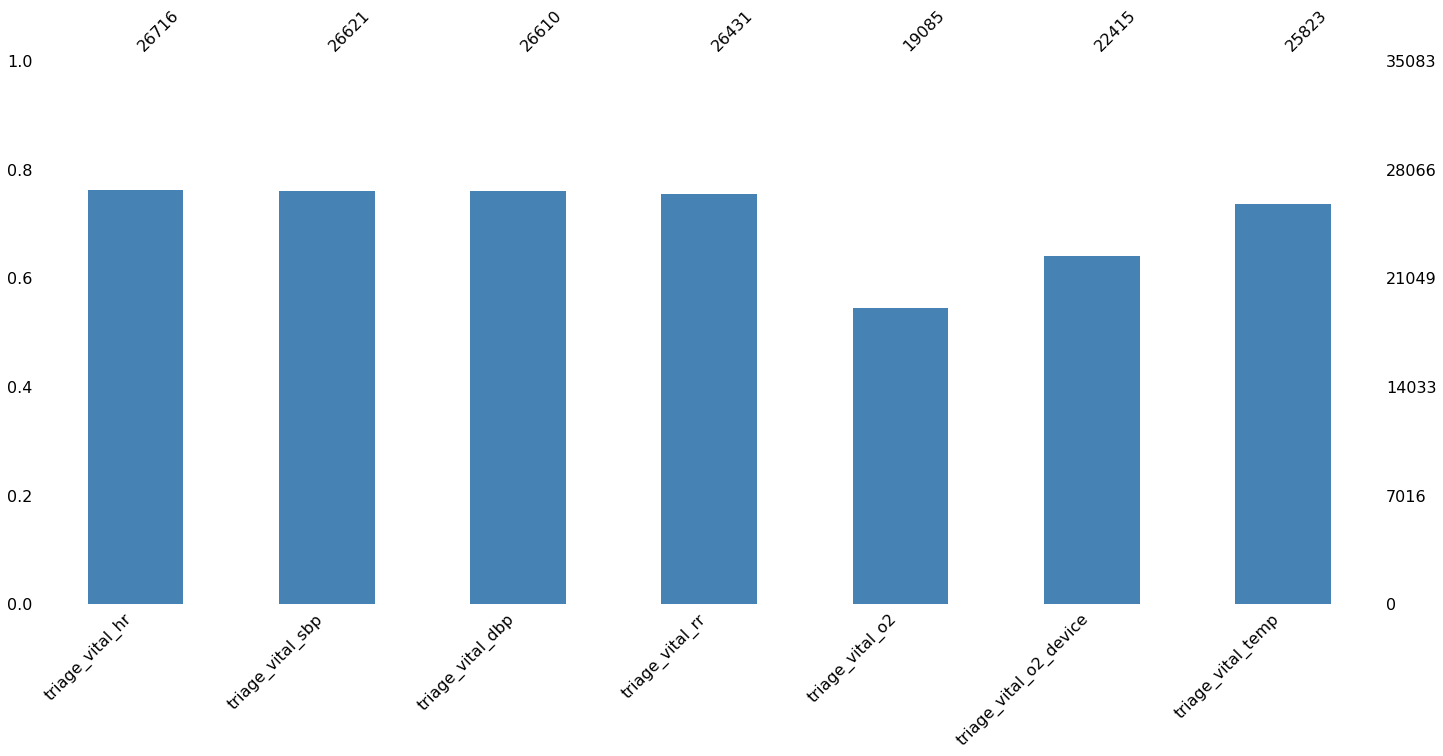

In [42]:
# Bar Graph of Missing Triage Data

# Admitted
msno.bar(clean[clean['disposition']=='Admit'][['triage_vital_hr','triage_vital_sbp','triage_vital_dbp','triage_vital_rr','triage_vital_o2','triage_vital_o2_device','triage_vital_temp']],
         color='sandybrown')
plt.show()

# Discharged
msno.bar(clean[clean['disposition']=='Discharge'][['triage_vital_hr','triage_vital_sbp','triage_vital_dbp','triage_vital_rr','triage_vital_o2','triage_vital_o2_device','triage_vital_temp']],
         color='steelblue')
plt.show()

In [ ]:
# Check for zero-variance features
clean.describe().loc['std'].sort_values()

proteinua_last_yn                                0.0
glucoseua_last_yn                                0.0
ecodesfireburn                                   0.0
ketonesua_last_yn                                0.0
leukocytesua_last_yn                             0.0
                                                ... 
phencyclidine(pcp)screen,urine,noconf._min       NaN
epithelialcells_max                              NaN
phencyclidine(pcp)screen,urine,noconf._max       NaN
epithelialcells_median                           NaN
phencyclidine(pcp)screen,urine,noconf._median    NaN
Name: std, Length: 1076, dtype: float64

## Table 1 Describing the patient cohort

We separate categorical and numeric columns in the to create a table, summarizing the characteristics of the included patient cohort. Chi-square and Fisher exacts tests are used for categorical variables, and t-test are used for continuous variables.

From viewing this table, it's apparent that very few patients with an ESI of 1 are discharged. We also see that Hispanic or Latino patients are less likely to be admitted compared to Non-Hispanic patients. Black patients and patients with other race were also less likely to be admitted.

In [ ]:
# Create table 1

categorical_cols = ['dep_name','esi','gender','ethnicity','race_category','lang','religion_category','marital_status_category', 'employment_status_category','insurance_status',
                    'any_esi_yn','any_chief_complaints_yn','any_labs_yn','any_medical_hx_yn','any_medication_yn','any_vitals_yn',]

columns = ['dep_name','esi','age','gender','ethnicity','race_category','lang','religion_category','marital_status_category', 'employment_status_category','insurance_status',
           'any_esi_yn','any_chief_complaints_yn','any_labs_yn','any_medical_hx_yn','any_medication_yn','any_vitals_yn']


table1 = TableOne(clean, columns, categorical_cols)

table1 = TableOne(clean, columns, categorical_cols, groupby='disposition', pval=True) #nonnormal='GAD-7',pval=True)

print(table1)



                                                                   Grouped by disposition                                                  
                                                                                  Missing       Overall         Admit     Discharge P-Value
n                                                                                                 50000         14917         35083        
dep_name, n (%)                   A                                                     0  28899 (57.8)   9259 (62.1)  19640 (56.0)  <0.001
                                  B                                                        14754 (29.5)   4598 (30.8)  10156 (28.9)        
                                  C                                                         6347 (12.7)    1060 (7.1)   5287 (15.1)        
esi, n (%)                        1.0                                                 188     507 (1.0)     432 (2.9)      75 (0.2)  <0.001
                    

# Statistical Analyses

In this section, we check for any statistically significant associations (applying the Bonferroni correction) between several sensitive features including race, ethnicity, language, religion, and insurance status and the target outcome (admit_yn) and other features. White patients appeared more likely to have ESI scores of 1 or 2, indicating greater urgency, which is likely to correspond to greater likelihood of admission. Asian patients were less likely to have lab and medical history data. Our decision to perform median imputation may introduce bias, which could lead to lower accuracy for these patients.

In [ ]:
# Check for significant associations for categorical data

sens_cols = ['race_category','ethnicity','lang','religion_category','insurance_status']

cols = ['race_category','ethnicity','lang','religion_category','employment_status_category','insurance_status','esi',
        'any_esi_yn','any_chief_complaints_yn','any_labs_yn','any_medical_hx_yn','any_medication_yn','any_vitals_yn','admit_yn']

for sens_col in sens_cols:
  for col in cols:
    if sens_col == col:
      continue
    crosstab = pd.crosstab(clean[sens_col], clean[col])
    pval = chi2_contingency(crosstab)[1]
    if pval < 0.05/(len(sens_cols)-1)*(len(cols)-1):
      print(crosstab.apply(lambda r: r/r.sum(), axis=1))
      print('p-val: ',"{0:.6f}".format(pval),'\n')



ethnicity                         Hispanic or Latino  Non-Hispanic  \
race_category                                                        
American Indian or Alaska Native            0.085106      0.914894   
Asian or Pacific Islander                   0.021739      0.968227   
Black or African American                   0.015466      0.980381   
Other                                       0.847203      0.151921   
Unknown                                     0.608108      0.312500   
White or Caucasian                          0.037230      0.953369   

ethnicity                         Patient Refused   Unknown  
race_category                                                
American Indian or Alaska Native         0.000000  0.000000  
Asian or Pacific Islander                0.005017  0.005017  
Black or African American                0.001647  0.002506  
Other                                    0.000250  0.000626  
Unknown                                  0.020270  0.059122  
White

There is a statistically significant difference between Caucasian/White and African-American/Black individuals for insurance status. A Cramer's V value of value ~10.42 for 4 degrees of freedom is still very large. Also, if you look at the cross-tabulation, it is clear that there is a difference in insurance status based on the two races.

In [92]:
race_df = clean[clean['race_category'].isin(['Black or African American', 'White or Caucasian'])]

# Chi-Square for race and insurance statis
crosstab = pd.crosstab(race_df['race_category'],race_df['insurance_status'])
test = chi2_contingency(crosstab)

freedom = test[2] # degrees of freedom, 2
phi=((test[0]**2)/(len(race_df)*freedom))**(1/2)
pval = test[1]

print(crosstab)
print()
print("degrees of freedom:", freedom)
print("phi:", phi) # effect size of race on insurance status (2x2) of our chi-squared test
print("pval:", pval)


insurance_status           Commercial  Medicaid  Medicare  Other  Self pay
race_category                                                             
Black or African American        3337      7279      2086   1223        41
White or Caucasian              11267      5988      7843   1651        57

degrees of freedom: 4
phi: 10.424656509960467
pval: 0.0


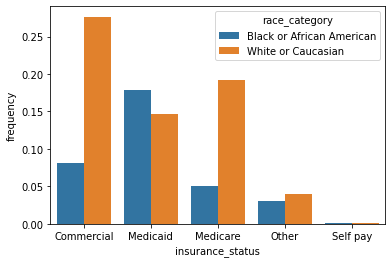

In [25]:
# visualization of the above

crosstab = pd.crosstab(race_df['race_category'],race_df['insurance_status'],normalize=True)
sns.barplot(data=crosstab.unstack().reset_index().rename(columns={0:'frequency'}), x='insurance_status', hue='race_category', y='frequency')
plt.show()

There appears to be a statistically significant difference in the frequencies of language spoken between Caucasian/White and African-American/Black. The phi value of 0.488 is very large, which means the effect of race on language is very large. Additionally, p-value is very small, indicating statistical significance. 

In [94]:
# Chi Square: language vs race (white or asian)
race_df = clean[clean['race_category'].isin(['Black or African American', 'White or Caucasian'])]

# Chi-Square: 2 categorical
crosstab = pd.crosstab(race_df['race_category'],race_df['lang'])
test = chi2_contingency(crosstab)
phi=((test[0]**2)/len(race_df))**(1/2)
pval = test[1]

print(crosstab)
print()
print(phi) 
print(pval)


lang                       English  Other
race_category                            
Black or African American    13881     85
White or Caucasian           26313    493

0.48833827349197756
3.0813984699208246e-23


There appears to be a statistically significant difference in the frequencies of any previous medication between Caucasian/White and African-American/Black. The phi value of 3.99 is very large, which means the effect of race on any previous medication is very large.

In [ ]:
# Chi Square: language vs race (white or asian)
race_df = clean[clean['race_category'].isin(['Black or African American', 'White or Caucasian'])]

# Chi-Square: 2 categorical
crosstab = pd.crosstab(race_df['race_category'],race_df['any_medication_yn'])
test = chi2_contingency(crosstab)
phi=((test[0]**2)/len(race_df))**(1/2)
pval = test[1]

print(crosstab)
print()
print(phi) # effect size of race on previous medication (2x2) of our chi-squared test
print(pval) # very small p-value

any_medication_yn              0     1
race_category                         
Black or African American  10858  3108
White or Caucasian         17155  9651

3.994960713668894
1.9180228443581468e-177


There is a statistically significant relationship between White/Caucasian and Asian with any previous medication, but the effect size is very small (phi small).

In [ ]:
# Chi Square: language vs race (white or asian)
race_df = clean[clean['race_category'].isin(['Asian or Pacific Islander', 'White or Caucasian'])]

# Chi-Square: 2 categorical
crosstab = pd.crosstab(race_df['race_category'],race_df['any_medication_yn'])
test = chi2_contingency(crosstab)
phi=((test[0]**2)/len(race_df))**(1/2)
pval = test[1]

print(crosstab.apply(lambda r: r/r.sum(), axis=1))
print()
print("phi", phi) # effect size of race on insurance status (2x2) of our chi-squared test
print("p-value", pval) # very small p-value

any_medication_yn                 0         1
race_category                                
Asian or Pacific Islander  0.762542  0.237458
White or Caucasian         0.639969  0.360031

phi 0.22795685473031913
p-value 8.098231567025001e-10


In [ ]:
# T-tests comparing mean values between Admitted and Discharged Patients

pd.set_option('max_rows', 100)

# Select float type columns
cols = clean.select_dtypes(include=['float']).columns

with np.errstate(divide='ignore'):
  res = []
  for col in cols:
    mean_admitted_patients = clean[clean['admit_yn']==1][col].mean()
    mean_discharged_patients = clean[clean['admit_yn']==0][col].mean()
    try:
      tt_res = ttest_ind(clean[clean['admit_yn']==1][col],
                        clean[clean['admit_yn']==0][col],
                        nan_policy='omit')
      pval = tt_res[1]
      if pval < 0.05/len(cols):
        new_res = {'feature':col,
                  'Mean, Admitted Patients':mean_admitted_patients, 
                  'Mean, Discharged Patients': mean_discharged_patients,
                  'p-val':"{0:.8f}".format(pval)}
        res.append(new_res)

    except:
      continue


In [ ]:
# Display features
pd.DataFrame(res).sort_values('p-val')

,feature,"Mean, Admitted Patients","Mean, Discharged Patients",p-val
0,esi,2.420398,3.262579,0.00000000
226,triage_vital_dbp,79.432102,80.862684,0.00000000
225,triage_vital_sbp,134.926083,132.844568,0.00000000
224,triage_vital_hr,88.791359,84.661729,0.00000000
223,wbc_median,9.076627,8.561619,0.00000000
...,...,...,...,...
293,cc_epistaxis,0.002019,0.004410,0.00005769
364,cc_toeinjury,0.000202,0.001518,0.00006138
204,phosphorus_median,3.487862,3.404010,0.00006527
288,cc_earproblem,0.000000,0.001060,0.00007211


In [ ]:
# One-way Anova comparing mean values between different race categories

cols = clean.select_dtypes(include=['float']).columns

with np.errstate(divide='ignore', invalid='ignore'):
  res = []
  for col in cols:
    mean_american_indian_patients = clean[clean['race_category']=='American Indian or Alaska Native'][col].mean()
    mean_asian_patients = clean[clean['race_category']=='Asian or Pacific Islander'][col].mean()
    mean_black_patients = clean[clean['race_category']=='Black or African American'][col].mean()
    mean_white_patients = clean[clean['race_category']=='White or Caucasian'][col].mean()
    mean_other_patients = clean[clean['race_category']=='Other'][col].mean()
    mean_unknown_patients = clean[clean['race_category']=='Unknown'][col].mean()
    try:
      anova_res = f_oneway(clean[clean['race_category']=='American Indian or Alaska Native'][col].dropna(),
                        clean[clean['race_category']=='Asian or Pacific Islander'][col].dropna(),
                        clean[clean['race_category']=='Black or African American'][col].dropna(),
                        clean[clean['race_category']=='White or Caucasian'][col].dropna(),
                        clean[clean['race_category']=='Other'][col].dropna(),
                        clean[clean['race_category']=='Unknown'][col].dropna())
      pval = anova_res[1]
      if pval < 0.05/len(cols):
        new_res = {'feature':col,
                  'Mean, AIAN Patients':mean_american_indian_patients, 
                  'Mean, Asian Patients':mean_asian_patients,
                  'Mean, Black Patients':mean_black_patients,
                  'Mean, White Patients':mean_white_patients, 
                  'Mean, Other': mean_other_patients,
                  'Mean, Unknown': mean_unknown_patients,
                  'p-val':"{0:.6f}".format(pval)}
        res.append(new_res)

    except:
      continue

# Display top 20 significant associations according to p-value
pd.DataFrame(res).sort_values('p-val').head(20)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3333: RuntimeWarning: Mean of empty slice.
  offset = alldata.mean()


,feature,"Mean, AIAN Patients","Mean, Asian Patients","Mean, Black Patients","Mean, White Patients","Mean, Other","Mean, Unknown",p-val
0,esi,2.808511,3.235993,3.130316,2.919410,3.088294,3.098139,0.000000
149,hematocrit_median,41.497826,37.517797,38.235141,38.967649,39.577326,39.256209,0.000000
150,hemoglobin_median,13.836957,12.572034,12.652720,13.053976,13.276615,13.092157,0.000000
152,immaturegranulocytes_median,0.550000,0.372000,0.387766,0.493905,0.417192,0.368182,0.000000
153,inr_median,1.030667,1.136875,1.106520,1.214356,1.060862,1.257451,0.000000
154,lymphs_median,23.169565,20.956356,28.214913,21.437702,25.451096,23.652303,0.000000
155,mch_median,29.880435,29.984711,28.974924,30.235873,29.515770,29.311364,0.000000
156,mchc_median,33.391304,33.529752,33.048770,33.445961,33.486279,33.363312,0.000000
157,mcv_median,89.354348,89.504545,87.587385,90.357044,88.060369,87.717857,0.000000
158,monocytes_median,7.608696,7.284711,7.791356,7.818098,7.408745,6.891776,0.000000


# Randomly Split Data into Training, Validation, and Testing Sets

We split the data into three sets, training (60%), validation (10%), and testing (30%). The validation set will be used to evaluate performance across models. The testing (holdout) set was only used to evaluate performance of the final model and was not used for tuning or model selection.

In [ ]:
final = clean.copy()
final = final.sample(frac=1, random_state=123).reset_index(drop=True)

# Split Train, Test, and Validation Sets
test_size = int(final.shape[0] * 0.3)
train_size = int(final.shape[0] * 0.6)

train_ids = final.head(train_size).index.unique()
test_ids = final.tail(test_size).index.unique()
valid_ids = final[(~final.index.isin(test_ids)) & (~final.index.isin(train_ids))].index.unique()

train = final.loc[train_ids]
valid = final.loc[valid_ids]
test = final.loc[test_ids]

print('Num train in test:',sum(train.index.isin(test_ids)))
print('Num test in train:',sum(test.index.isin(train_ids)))
print('Num valid in train:',sum(valid.index.isin(train_ids)))
print('Num valid in test:',sum(valid.index.isin(test_ids)))

train.shape, valid.shape, test.shape

Num train in test: 0
Num test in train: 0
Num valid in train: 0
Num valid in test: 0


((30000, 1091), (5000, 1091), (15000, 1091))

In [ ]:
# Train: Separate features and label
X_train = train.drop(['disposition','admit_yn'], axis=1)
y_train = train['admit_yn']

In [ ]:
# Valid: Separate features and label
X_valid = valid.drop(['disposition','admit_yn'], axis=1)
y_valid = valid['admit_yn']

In [ ]:
# Test: Separate features and label
X_test = test.drop(['disposition','admit_yn'], axis=1)
y_test = test['admit_yn']

# Feature Engineering

## Imputation
After splitting the data, we perform median imputation on the numeric lab and vitals values from the original columns, dropping any columns that are completely missing. We previously created indicator variables for the presence of each lab and vitals data element. By taking the median, we are assuming patients without any lab or vitals data are more likely to fall in the normal range. 

In [ ]:
# Display column indexes and corresponding column names
[(X_train.columns.get_loc(col),col) for col in X_train.columns]

[(0, 'dep_name'),
 (1, 'esi'),
 (2, 'age'),
 (3, 'gender'),
 (4, 'ethnicity'),
 (5, 'lang'),
 (6, 'insurance_status'),
 (7, 'arrivalmonth'),
 (8, 'arrivalday'),
 (9, 'arrivalhour_bin'),
 (10, '2ndarymalig'),
 (11, 'abdomhernia'),
 (12, 'abdomnlpain'),
 (13, 'abortcompl'),
 (14, 'acqfootdef'),
 (15, 'acrenlfail'),
 (16, 'acutecvd'),
 (17, 'acutemi'),
 (18, 'acutphanm'),
 (19, 'adjustmentdisorders'),
 (20, 'adltrespfl'),
 (21, 'alcoholrelateddisorders'),
 (22, 'allergy'),
 (23, 'amniosdx'),
 (24, 'analrectal'),
 (25, 'anemia'),
 (26, 'aneurysm'),
 (27, 'anxietydisorders'),
 (28, 'appendicitis'),
 (29, 'artembolism'),
 (30, 'asppneumon'),
 (31, 'asthma'),
 (32, 'attentiondeficitconductdisruptivebeha'),
 (33, 'backproblem'),
 (34, 'biliarydx'),
 (35, 'birthasphyx'),
 (36, 'birthtrauma'),
 (37, 'bladdercncr'),
 (38, 'blindness'),
 (39, 'bnignutneo'),
 (40, 'bonectcncr'),
 (41, 'bph'),
 (42, 'brainnscan'),
 (43, 'breastcancr'),
 (44, 'breastdx'),
 (45, 'brnchlngca'),
 (46, 'bronchitis'),
 (4

In [ ]:
# Perform median imputation on Age using the median from the training set
X_train['age'].fillna(X_train['age'].median(),inplace=True)
X_valid['age'].fillna(X_train['age'].median(),inplace=True)
X_test['age'].fillna(X_train['age'].median(),inplace=True)

# Perform median imputation on ESI Acuity using the median from the training set
X_train['esi'].fillna(X_train['esi'].median(),inplace=True)
X_valid['esi'].fillna(X_train['esi'].median(),inplace=True)
X_test['esi'].fillna(X_train['esi'].median(),inplace=True)

# Zero-fill missing chief complaints
X_train.iloc[:,765:965] = X_train.iloc[:,765:965].fillna(0)
X_valid.iloc[:,765:965] = X_valid.iloc[:,765:965].fillna(0)
X_test.iloc[:,765:965] = X_test.iloc[:,765:965].fillna(0)

In [ ]:
# Drop labs and vitals that are completely missing from the training set
train_labs_vitals = X_train.copy().iloc[:,293:707].dropna(axis=1, how='all')

# Drop the same columns from the validation and testing sets
valid_labs_vitals = X_valid.copy().iloc[:,293:707].loc[:,train_labs_vitals.columns]
test_labs_vitals = X_test.copy().iloc[:,293:707].loc[:,train_labs_vitals.columns]



In [ ]:
# Perform median imputation on labs, vitals
median_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_labs_vitals.iloc[:,:] = median_imputer.fit_transform(train_labs_vitals)

# Apply the fitted imputations (from the training data) to the validation and testing sets
valid_labs_vitals.iloc[:,:] = median_imputer.transform(valid_labs_vitals)
test_labs_vitals.iloc[:,:] = median_imputer.transform(test_labs_vitals)

# Merge imputed lab and vitals data
X_train = X_train.drop(X_train.columns[293:707], axis=1)
X_train = X_train.merge(train_labs_vitals, left_index=True, right_index=True, how='inner')

X_valid = X_valid.drop(X_valid.columns[293:707], axis=1)
X_valid = X_valid.merge(valid_labs_vitals, left_index=True, right_index=True, how='inner')

X_test = X_test.drop(X_test.columns[293:707], axis=1)
X_test = X_test.merge(test_labs_vitals, left_index=True, right_index=True, how='inner')

In [ ]:
# Check for any remaining missing values
X_test.isna().sum().sort_values(ascending=False)

o2_device_median                   0
cc_abdominalpainpregnant           0
cc_armpain                         0
cc_arminjury                       0
cc_anxiety                         0
                                  ..
immaturegrans(abs)_last            0
hemoglobin_last                    0
hematocrit_last                    0
hco3calculated,venous(poc)_last    0
dep_name                           0
Length: 1080, dtype: int64

## One-Hot Encoding 

We next use one-hot encoding to create numeric features from the remaining categorical features. We use the training data for this procedure to determine which binary columns are created. Then we align the validation and testing sets with the training data.

While we could drop the first column to prevent the creation of redundant, correlated columns through the get_dummies function, we would not be able to align the validation and test sets. Instead, we will manually drop these later.

In [ ]:
# One-hot encode categorical features

X_train = pd.get_dummies(X_train, columns=['gender','race_category','ethnicity','lang','religion_category','marital_status_category','employment_status_category','insurance_status',
                                                  'previous_disposition_category','dep_name','arrival_mode_category','arrivalmonth','arrivalday','arrivalhour_bin'])

X_valid = pd.get_dummies(X_valid, columns=['gender','race_category','ethnicity','lang','religion_category','marital_status_category','employment_status_category','insurance_status',
                                                  'previous_disposition_category','dep_name','arrival_mode_category','arrivalmonth','arrivalday','arrivalhour_bin'])

X_test = pd.get_dummies(X_test, columns=['gender','race_category','ethnicity','lang','religion_category','marital_status_category','employment_status_category','insurance_status',
                                                  'previous_disposition_category','dep_name','arrival_mode_category','arrivalmonth','arrivalday','arrivalhour_bin'])

X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)


X_test.shape



(15000, 1138)

After one-hot encoding, we drop the one of the newly created binary columns for each category. This was done separately to ensure the training, validation, and testing sets would be aligned.

In [ ]:
# Drop Columns to remove redundant, correlated features
drop_first_list = ['gender_Female','race_category_Other','ethnicity_Hispanic or Latino','lang_Other',
                   'religion_category_Other','marital_status_category_Other','employment_status_category_Other',
                   'insurance_status_Other','previous_disposition_category_Other','dep_name_A','arrival_mode_category_Other',
                   'arrivalmonth_April','arrivalday_Friday','arrivalhour_bin_03-06']

X_train.drop(columns=drop_first_list, inplace=True)
X_valid.drop(columns=drop_first_list, inplace=True)
X_test.drop(columns=drop_first_list, inplace=True)

## PCA

During EDA, we observed a large number of correlated features within the raw data. Here we will use PCA to perform dimensionality reduction.
In this section, we first scale the data to ensure all features are comparable. Then we deploy PCA to find the number of components that best explain the variance. We display the cumulative sum of the explained variance to identify a point where we reach diminishing returns. 

After determining the optimal number of components, we rerun the PCA process with the predetermined number of components. The resultant transformed dataset will be used for model building. 

In order to prevent data leakage we scale the validation and testing sets based on the fitted training data. We will also use the fitted (from the training data) PCA model to transform the validation and testing sets.


In [ ]:
# Scale data
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Scale validation and test sets
X_valid_std = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
X_train_std.shape

(30000, 1124)

In [ ]:
# PCA
pca = PCA(n_components=1124)
pca.fit(X_train_std)

PCA(copy=True, iterated_power='auto', n_components=1124, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

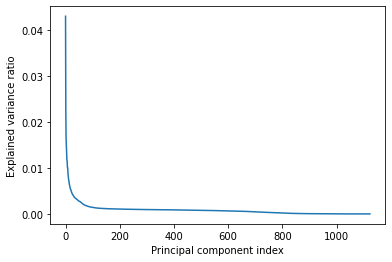

In [ ]:
# Plot Explained variance ratio
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

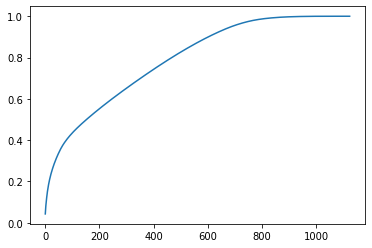

In [ ]:
# Visualize the cumulative sum of the explained variance ratio
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance)
plt.show()

In [ ]:
# Fit the PCA on the training data
pca = PCA(n_components=500)
pca.fit(X_train_std)
# and transform it
X_train_pca = pca.transform(X_train_std)

# Building Models

## Logistic Regression (with PCA)

We first build a logistic regression model using the fitted PCA data. We opted to use l1 regularization, which may lead to a more parsimonious model.

In [ ]:
# Set parameters
n_folds = 5
C_values = [0.001,0.01,1,10,100]

# Then train cross validated logistic regression
lrcv_pca = LogisticRegressionCV(Cs=C_values, cv=n_folds, penalty='l1', 
                           refit=False, scoring='roc_auc', 
                           solver='liblinear', random_state=123, max_iter=50,
                           fit_intercept=False, verbose=True, n_jobs=-1)

lrcv_pca.fit(X_train_pca, y_train.values.ravel())
print('CV Max AUC:', lrcv_pca.scores_[1].max())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CV Max AUC: 0.9100845763510146


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


In [ ]:
X_valid_pca = pca.transform(X_valid_std)
y_pred = lrcv_pca.predict(X_valid_pca)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lrcv_pca.score(X_valid_pca, y_valid)))

Accuracy of logistic regression classifier on test set: 0.91


In [ ]:
confusion_matrix = confusion_matrix(y_valid, y_pred)
print(confusion_matrix)

[[3064  401]
 [ 371 1164]]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3465
           1       0.74      0.76      0.75      1535

    accuracy                           0.85      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.85      0.85      0.85      5000



**ROC Curve**

The receiver operating characteristic (ROC) curve is a common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

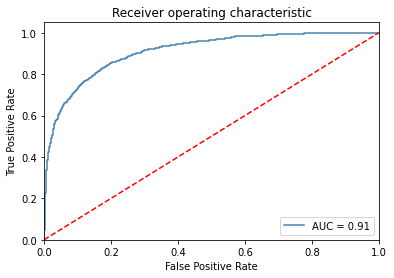

In [ ]:
# Display ROC Curve
valid_preds = pd.Series(lrcv_pca.predict_proba(X_valid_pca)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T
roc_plot(y_valid,valid_preds)

We display the odds ratios (OR) of the individual components in the model. An OR > 1, indicates an increased likelihood of admission.

In [ ]:
# print out the coefficients
# print(lr.coef_, lr.intercept_)

coefficients = lrcv_pca.coef_[0]

coef_df = pd.DataFrame(coefficients, columns=["Coefficient"])
coef_df['Abs Coef'] = abs(coef_df['Coefficient'])
coef_df['OR'] = np.exp(coef_df['Coefficient'])

# Display Top 25 Features
coef_df = coef_df.sort_values('Abs Coef', ascending=False)[['Coefficient','OR']]

coef_df

,Coefficient,OR
24,-0.474412,0.622251
25,-0.311789,0.732136
9,-0.278324,0.757051
1,0.276732,1.318812
14,-0.258879,0.771917
...,...,...
140,-0.000133,0.999867
363,0.000069,1.000069
93,0.000062,1.000062
204,-0.000038,0.999962


## Logistic Regression (without PCA)

The second modeling approach again uses logistic regression, but without PCA. We've provided smaller C_values for a stronger regularization (and lead to fewer features).

In [ ]:
# Set parameters
n_folds = 5
C_values = [0.001,0.01,1]

# Fit model
lrcv_clf = LogisticRegressionCV(Cs=C_values, cv=n_folds, penalty='l1', 
                           refit=False, scoring='roc_auc', max_iter=50,
                           solver='liblinear', random_state=42,
                           fit_intercept=False, n_jobs=-1)

lrcv_clf.fit(X_train_std, y_train.values.ravel())

print('CV Max AUC:', lrcv_clf.scores_[1].max())

CV Max AUC: 0.9189727388958188


One benefit of using logistic regression is its greater interpretability. We can obtain coefficients from the model and calculate odds ratios. 

When looking at the largest coefficients by absolute value, it's apparent that many of the top features are medication categories. The ESI acuity level was also one of the strongest predictors of admission.

In [ ]:
# Coefficients

feature_list = list(X_train_std.columns)
coefficients = lrcv_clf.coef_[0]

feature_coefficients = list(zip(feature_list, coefficients))
coef_list = [list(x) for x in feature_coefficients]
coef_df = pd.DataFrame(coef_list, columns=["Variable", "Coefficient"])
coef_df['Abs Coef'] = abs(coef_df['Coefficient'])
coef_df['OR'] = np.exp(coef_df['Coefficient'])


# Display Top 25 Features Overall
coef_df.sort_values('Abs Coef', ascending=False)[['Variable','Coefficient','OR']][0:25]

,Variable,Coefficient,OR
320,meds_colonystimulatingfactors,0.893589,2.443886
327,meds_gastrointestinal,0.775915,2.172579
0,esi,-0.710515,0.491391
324,meds_diuretics,0.352187,1.422175
295,meds_analgesics,0.342897,1.409024
317,meds_cardiacdrugs,0.296388,1.344991
341,meds_vitamins,0.278277,1.320852
302,meds_anticoagulants,0.246969,1.280139
1092,insurance_status_Self pay,0.237721,1.268355
300,meds_antiasthmatics,0.228561,1.256790


Here we focus on the some of the sensitive subgroups to see whether/and to what extent they are featured in the model. The coefficients for many of the sensitivities categories have shrunk to zero, although patients in the White or Caucasian category have slightly increased odds admission. One exception is the insurance category of self-pay, which may reflect the urgency of the visit. For example, it's reasonable to expect those paying out of pocket would less likely to use the ED for non-urgent issues.

In [ ]:
coef_df[coef_df.Variable.isin(['race_category_American Indian or Alaska Native','race_category_Asian or Pacific Islander','race_category_Black or African American', 'race_category_Unknown',
                              'race_category_White or Caucasian', 'ethnicity_Non-Hispanic','ethnicity_Patient Refused', 'ethnicity_Unknown', 'lang_English',
                              'religion_category_Christian', 'religion_category_Jewish','religion_category_Muslim', 'religion_category_None','religion_category_Unknown',
                              'insurance_status_Commercial', 'insurance_status_Medicaid','insurance_status_Medicare', 'insurance_status_Self pay'])]

,Variable,Coefficient,Abs Coef,OR
1067,race_category_American Indian or Alaska Native,0.000000,0.000000,1.000000
1068,race_category_Asian or Pacific Islander,0.004058,0.004058,1.004066
1069,race_category_Black or African American,0.000000,0.000000,1.000000
1070,race_category_Unknown,0.000000,0.000000,1.000000
1071,race_category_White or Caucasian,0.023240,0.023240,1.023513
1072,ethnicity_Non-Hispanic,0.024842,0.024842,1.025154
1073,ethnicity_Patient Refused,0.000000,0.000000,1.000000
1074,ethnicity_Unknown,0.000000,0.000000,1.000000
1075,lang_English,0.000222,0.000222,1.000222
1076,religion_category_Christian,0.000000,0.000000,1.000000


We calculate the AUC for the logistic regression model using the validation set.

Validation:  0.9152693994387804


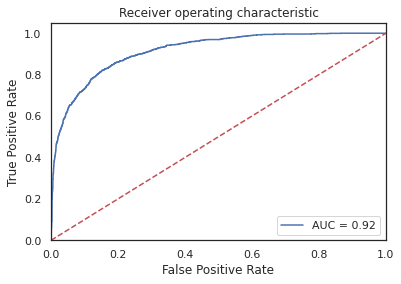

In [ ]:
# Evaluate performance using the 10% validation set

train_preds = pd.Series(lrcv_clf.predict_proba(X_train_std)[:,1])
train_preds = train_preds.values
train_preds = np.array([train_preds,train_preds]).T

valid_preds = pd.Series(lrcv_clf.predict_proba(X_valid_std)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T

fpr, tpr, thresholds = metrics.roc_curve(y_valid, valid_preds[:, 1])
auc = metrics.auc(fpr, tpr)
print('Validation: ',str(auc))

# ROC 
roc_plot(y_valid,valid_preds)


We create an alternative version of this model that excludes race, ethnicity, language, religion, and insurance status from the features. This model obtains an AUC of about 0.914, so it performs almost as well as the model that incorporated those features.

In [ ]:
# Excluded Features
excluded_features = ['race_category_American Indian or Alaska Native','race_category_Asian or Pacific Islander','race_category_Black or African American', 'race_category_Unknown',
                     'race_category_White or Caucasian', 'ethnicity_Non-Hispanic','ethnicity_Patient Refused', 'ethnicity_Unknown', 'lang_English','religion_category_Christian', 
                     'religion_category_Jewish','religion_category_Muslim', 'religion_category_None','religion_category_Unknown','insurance_status_Commercial',
                     'insurance_status_Medicaid','insurance_status_Medicare', 'insurance_status_Self pay']

# New List of Features
new_features = [col for col in X_train_std.columns if col not in excluded_features]

# Set parameters
n_folds = 5
C_values = [0.001,0.01,1]

# # Fit model
lrcv_alt = LogisticRegressionCV(Cs=C_values, cv=n_folds, penalty='l1', 
                           refit=False, scoring='roc_auc', max_iter=50,
                           solver='liblinear', random_state=42,
                           fit_intercept=False, n_jobs=-1)

lrcv_alt.fit(X_train_std[new_features], y_train.values.ravel())

print('CV Max AUC:', lrcv_alt.scores_[1].max())

CV Max AUC: 0.9178853077552566


Validation:  0.9135737082316887


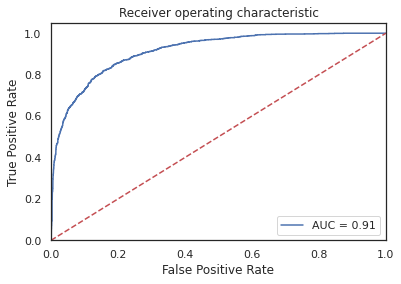

In [ ]:
# Evaluate performance using the 10% validation set
valid_preds = pd.Series(lrcv_alt.predict_proba(X_valid_std[new_features])[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T

fpr, tpr, thresholds = metrics.roc_curve(y_valid, valid_preds[:, 1])
auc = metrics.auc(fpr, tpr)
print('Validation: ',str(auc))

# ROC 
roc_plot(y_valid,valid_preds)


## Random Forest Classifier (with PCA)

The next model uses a random forest classifier with the PCA results. We use grid search for tuning hyperparameters with 5-fold cross validation in order to reduce overfitting.

In [ ]:
# Random Forest
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8,12],
    'criterion' :['entropy']
}

rfc_gs = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rfc_gs.fit(X_train_pca, y_train.values.ravel())

print('Best Parameters:', rfc_gs.best_params_)


In [ ]:
# Display Feature Importances
importances = rfc_gs.best_estimator_.feature_importances_
importances

array([0.04892532, 0.0761282 , 0.02973882, 0.01439727, 0.04373342,
       0.01316209, 0.01749129, 0.0418546 , 0.03669227, 0.0148606 ,
       0.01419774, 0.04202703, 0.01293743, 0.03141408, 0.01862612,
       0.01369464, 0.01247457, 0.01333332, 0.01384024, 0.01335232,
       0.01184291, 0.02162244, 0.01336608, 0.01526599, 0.01480975,
       0.01226322, 0.04814177, 0.01921065, 0.01151997, 0.01795902,
       0.01657657, 0.01335289, 0.01266355, 0.02077466, 0.01108097,
       0.0142772 , 0.01832105, 0.01283118, 0.01835861, 0.01270026,
       0.0138815 , 0.01232388, 0.012407  , 0.0149687 , 0.01438021,
       0.01261603, 0.01339734, 0.01518868, 0.01682954, 0.01418702])

Validation:  0.8662541328918554


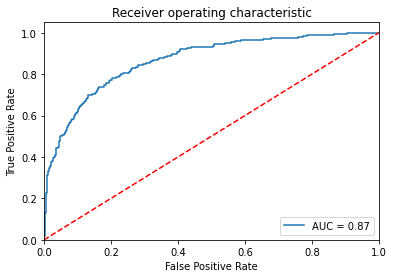

In [ ]:
# Evaluate performance using the 10% validation set

valid_preds = pd.Series(rfc_gs.predict_proba(X_valid_pca)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T

fpr, tpr, thresholds = metrics.roc_curve(y_valid, valid_preds[:, 1])
auc = metrics.auc(fpr, tpr)
print('Validation: ',str(auc))

# ROC 
roc_plot(y_valid,valid_preds)


## Random Forest Classifier (without PCA)

In [ ]:
# Random Forest
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8,12],
    'criterion' :['entropy']
}

rfc_gs = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rfc_gs.fit(X_train, y_train.values.ravel())

print('Best Parameters:', rfc_gs.best_params_)


Best Parameters: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 200}


### Feature Importance
Running the random forest classifier without PCA resulted in a model with more than 900 features with non-zero importance. ESI again is one of the most important features. The race category of White or Caucasian is among the top 100 features.

In [ ]:
# Display Feature Importances
importances = rfc_gs.best_estimator_.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

keep_features = []
for f in range(X_train.shape[1]):
    if importances[indices[f]] != 0:
        keep_features.append(X_train.columns[indices[f]])
        print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature any_medication_yn (0.060452)
2. feature esi (0.052659)
3. feature meds_cardiovascular (0.034937)
4. feature age (0.030492)
5. feature meds_gastrointestinal (0.029456)
6. feature meds_vitamins (0.018784)
7. feature meds_antiplateletdrugs (0.016936)
8. feature meds_analgesics (0.016314)
9. feature employment_status_category_Retired (0.016199)
10. feature meds_psychotherapeuticdrugs (0.016048)
11. feature meds_diuretics (0.013774)
12. feature meds_cardiacdrugs (0.013145)
13. feature meds_elect/caloric/h2o (0.011214)
14. feature charlson (0.010824)
15. feature meds_antihyperglycemics (0.009271)
16. feature insurance_status_Medicare (0.009225)
17. feature previous_disposition_category_Admit (0.008469)
18. feature htn (0.008230)
19. feature meds_cnsdrugs (0.007286)
20. feature meds_antiasthmatics (0.006533)
21. feature lymphs_min (0.006374)
22. feature meds_eentpreps (0.006218)
23. feature meds_antiarthritics (0.006066)
24. feature absolutelymphocytecount_last (0.

Validation:  0.8933725828844603


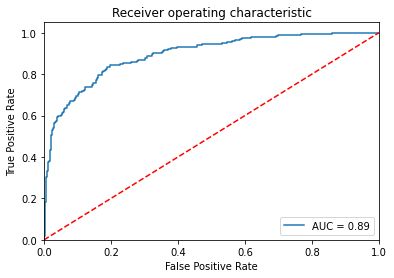

In [ ]:
# Evaluate performance using the 10% validation set

valid_preds = pd.Series(rfc_gs.predict_proba(X_valid)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T

fpr, tpr, thresholds = metrics.roc_curve(y_valid, valid_preds[:, 1])
auc = metrics.auc(fpr, tpr)
print('Validation: ',str(auc))

# ROC 
roc_plot(y_valid,valid_preds)


## Gradient Boosting Classifier (without PCA)

We also used a gradient boosting classifier, which resulted in fewer features with non-zero importance (n=290) and a higher AUC (0.91) compared to the random forest model. Again, the race category of White or Caucasian was still in the top 100 features.

In [ ]:
# Gradient Boosting Classifier with Random Search

learn_rate_list = np.linspace(0.001, 2, 150)
min_samples_leaf_list = list(range(1,51))

parameter_grid = {
	'learning_rate': learn_rate_list,
	'min_samples_leaf': min_samples_leaf_list}

gbc_rs = RandomizedSearchCV(
	estimator = GradientBoostingClassifier(),
	param_distributions = parameter_grid,
	n_iter = 10,
	scoring = 'accuracy',
	n_jobs = -1,
	cv = 5,
	refit = True,
	return_train_score = True)

gbc_rs.fit(X_train, y_train)

rand_x = list(gbc_rs.cv_results_['param_learning_rate'])
rand_y = list(gbc_rs.cv_results_['param_min_samples_leaf'])

In [ ]:
# Display Feature Importances
importances = gbc_rs.best_estimator_.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

keep_features = []
for f in range(X_train.shape[1]):
    if importances[indices[f]] != 0:
        keep_features.append(X_train.columns[indices[f]])
        print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature any_medication_yn (0.455008)
2. feature esi (0.189260)
3. feature age (0.036056)
4. feature employment_status_category_Retired (0.018914)
5. feature previous_disposition_category_Admit (0.018679)
6. feature triage_vital_hr (0.013102)
7. feature cc_alcoholintoxication (0.007829)
8. feature n_admissions (0.007562)
9. feature insurance_status_Self pay (0.006151)
10. feature triage_vital_o2 (0.005639)
11. feature lymphs_median (0.004694)
12. feature rbc_median (0.004452)
13. feature lymphs_max (0.004304)
14. feature triage_vital_sbp (0.004207)
15. feature calcium_max (0.004119)
16. feature meds_cardiovascular (0.003985)
17. feature bun/creatratio_max (0.003880)
18. feature calculatedhco3(poc)i_last (0.003845)
19. feature arrival_mode_category_Car (0.003488)
20. feature pulse_min (0.003210)
21. feature dep_name_B (0.003094)
22. feature sbp_median (0.003068)
23. feature meds_antiarthritics (0.002945)
24. feature triage_vital_temp (0.002935)
25. feature employment_

Validation:  0.9139571276580518


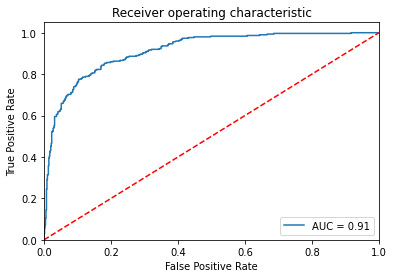

In [ ]:
# Evaluate performance using the 10% validation set
valid_preds = pd.Series(gbc_rs.predict_proba(X_valid)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T

fpr, tpr, thresholds = metrics.roc_curve(y_valid, valid_preds[:, 1])
auc = metrics.auc(fpr, tpr)
print('Validation: ',str(auc))

# ROC 
roc_plot(y_valid,valid_preds)

## Feedforward Network
Apart from traditional machine learning models, we also want to explore a deep learning model. Therefore, in the next section, we constructed a deep neural network consisted of multiple layers and tuned the model to evaluate the performance.

In [44]:
#!pip install mxnet

In [ ]:
import mxnet as mx
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms
from mxnet import np
import shutil
from mxnet import np, npx
from mxnet.gluon import nn
from mxnet import gluon, autograd, ndarray, nd

In [ ]:
ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()

In [ ]:
print(type(X_train))
print(X_train.dtypes)

<class 'pandas.core.frame.DataFrame'>
esi                                                      float64
age                                                        int64
2ndarymalig                                                int64
abdomhernia                                                int64
abdomnlpain                                                int64
abortcompl                                                 int64
acqfootdef                                                 int64
acrenlfail                                                 int64
acutecvd                                                   int64
acutemi                                                    int64
acutphanm                                                  int64
adjustmentdisorders                                        int64
adltrespfl                                                 int64
alcoholrelateddisorders                                    int64
allergy                                             

Since MXNet only supports float32 data type in the model, we convert all of our data types in the dataset into float32 and then feed them into the dataloaders.

In [ ]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
print(X_train.dtypes)

esi                                                      float32
age                                                      float32
2ndarymalig                                              float32
abdomhernia                                              float32
abdomnlpain                                              float32
abortcompl                                               float32
acqfootdef                                               float32
acrenlfail                                               float32
acutecvd                                                 float32
acutemi                                                  float32
acutphanm                                                float32
adjustmentdisorders                                      float32
adltrespfl                                               float32
alcoholrelateddisorders                                  float32
allergy                                                  float32
amniosdx                 

In [ ]:
print(y_train.dtypes)
print(y_test.dtypes)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

float32
float32
(6000, 1121)
(6000,)
(3000, 1121)
(3000,)


In [ ]:
train_dataset = gluon.data.dataset.ArrayDataset(X_train.values, y_train.values)
valid_dataset = gluon.data.dataset.ArrayDataset(X_valid.values, y_valid.values)
test_dataset = gluon.data.dataset.ArrayDataset(X_test.values, y_test.values)

In [ ]:
train_loader = mx.gluon.data.DataLoader(train_dataset, 10, shuffle=True)
valid_loader = mx.gluon.data.DataLoader(valid_dataset, 1, shuffle=False)
test_loader = mx.gluon.data.DataLoader(test_dataset, 1, shuffle=False)

We experimented with different composition of the model layers. For example, we have tried a model with more dense layers with neurons 950, 750, 550, 350, 150, 50, 2. However, the model did not perform as well as the one set up below. We believe that more layers does not necessarily mean better performance, so our final model parameters are shown below.

In [ ]:
def construct_ff_net():
  ff_net = gluon.nn.Sequential()
  with ff_net.name_scope():
    ff_net.add(nn.Dense(850, activation="relu"))
    ff_net.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
    ff_net.add(nn.Dense(550, activation="relu"))
    ff_net.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
    ff_net.add(nn.Dense(250, activation="relu"))
    ff_net.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
    ff_net.add(nn.Dense(50, activation="relu"))
    ff_net.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
    ff_net.add(nn.Dense(2))

  return ff_net

In [ ]:
def train_ff_network(net, train_loader, criterion, trainer, metric, epochs):

  for e in range(epochs):
    train_loss = 0
    metric.reset()

    for i, (data, label) in enumerate(train_loader):
      data = data.as_in_context(ctx)
      label = label.as_in_context(ctx)
      with autograd.record():
        output = net(data)
        # output = mx.nd.argmax(output, axis=1)
        loss = criterion(output, label)
      
      train_loss += nd.sum(loss.as_nd_ndarray()).asscalar()
      loss.backward()
      trainer.step(data.shape[0])
      metric.update(label, output.as_nd_ndarray())

    #average loss for each epoch
    mean_loss = train_loss / len(train_loader)
    train_acc = evaluate_accuracy(train_loader, net)
    print("Epoch %s. Train_acc %s, Avg_loss %s" % (e, train_acc, mean_loss))

  final_training_accuracy = train_acc
  final_training_loss = mean_loss
  return final_training_loss, final_training_accuracy, net

In [ ]:
def evaluate_accuracy(data_iterator, net):
  acc = mx.metric.Accuracy()
  for i, (data, label) in enumerate(data_iterator):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    predictions = nd.softmax(output)
    # predictions = nd.argmax(output.as_nd_ndarray(), axis=1)
    acc.update(preds=predictions, labels=label)
  return acc.get()[1]

In [ ]:
def test_ff_model(net, criterion, test_loader, metric):
  testing_loss = 0
  for i, (data, label) in enumerate(test_loader):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    loss = criterion(output, label)
    predictions = nd.softmax(output)
    metric.update(label, predictions)
    testing_loss += loss.asscalar()

  testing_loss /= len(test_loader)
  _, testing_accuracy = metric.get()
  return  testing_loss, testing_accuracy

Apart from experimenting with different composition of neurons and different number of layers, we also tried various learning rates. Here, we set our epoch to be 50, although ideally we would want to train the model at least 100 epochs, due to computing power and time limitations as each iteration takes around 6 hours to complete. The learning rates are loaded in a list. Based on experiments, 0.001 seems to be very slow in the beginning, whereas 0.1 is relatively fast. However, the eventual accuracy does not differ too much from each other, which means if we run enough epochs the model eventually finds its local minima still. In terms of loss, we are using softmax cross entropy loss, because it is a good function to evaluate classification algorithms and gives us a probability to work with to get to the final prediction.

For each learning rate, we train the model on the train dataset, then validate on the validation dataset. After each validation, we update the optimal model based on the validation accuracy. At the end, our optimal model holds the best performance and we use that model to run on test data. 

Eventually our model has around 83% accuracy on test data, which performs fairly well overall.

In [ ]:
# train the feedforward net with different learning rate
ff_net = construct_ff_net()
ff_net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

lr = [0.01, 0.05, 0.001, 0.1]
epochs = 50
metric = mx.metric.Accuracy()
criterion = gluon.loss.SoftmaxCrossEntropyLoss()
opt_acc = 0

for rate in lr:
  print("Learning rate: ", rate)
  trainer = gluon.Trainer(ff_net.collect_params(), 'adam', {'learning_rate': rate})
  training_loss, training_accuracy, model = train_ff_network(ff_net, train_loader, criterion, trainer, metric, epochs)
  print("Training loss: ", str(training_loss), "Training accuracy: ", str(training_accuracy))

  # validate on the validation data and save the best model
  valid_loss, valid_accuracy = test_ff_model(ff_net, criterion, valid_loader, metric)
  print("Validation loss: ", str(valid_loss), "Validation accuracy: ", str(valid_accuracy))
  if(valid_accuracy > opt_acc):
    print("updated opt_model")
    opt_acc = valid_accuracy
    opt_model = model

testing_loss, testing_accuracy = test_ff_model(opt_model, criterion, test_loader, metric)
print("Testing loss: ", str(testing_loss), "Testing accuracy: ", str(testing_accuracy))

Learning rate:  0.01
Epoch 0. Train_acc 0.7083333333333334, Avg_loss 5.612518558502197
Epoch 1. Train_acc 0.7091666666666666, Avg_loss 4.863649616241455
Epoch 2. Train_acc 0.781, Avg_loss 4.652662789026897
Epoch 3. Train_acc 0.8288333333333333, Avg_loss 4.384177820483844
Epoch 4. Train_acc 0.7333333333333333, Avg_loss 4.202797899742921
Epoch 5. Train_acc 0.8328333333333333, Avg_loss 4.2025170248746875
Epoch 6. Train_acc 0.697, Avg_loss 4.177158878544966
Epoch 7. Train_acc 0.8413333333333334, Avg_loss 4.231387994289398
Epoch 8. Train_acc 0.7838333333333334, Avg_loss 4.106675848762194
Epoch 9. Train_acc 0.8533333333333334, Avg_loss 4.050334074596564
Epoch 10. Train_acc 0.789, Avg_loss 4.039624496897062
Epoch 11. Train_acc 0.8388333333333333, Avg_loss 3.9984123557806015
Epoch 12. Train_acc 0.8253333333333334, Avg_loss 4.198877998789151
Epoch 13. Train_acc 0.795, Avg_loss 3.970254845122496
Epoch 14. Train_acc 0.7873333333333333, Avg_loss 3.8964026178916296
Epoch 15. Train_acc 0.82766666666

# Final Model Evaluation

We selected the logistic regression model (without PCA) because its AUC (0.915) was comparable to the other models, but it also added greater interpretability. We proceed to evaluate specific performance metrics for this model. We'll use the validation set to determine a threshold for the predictions. Then we'll evaluate this model against the test data. 

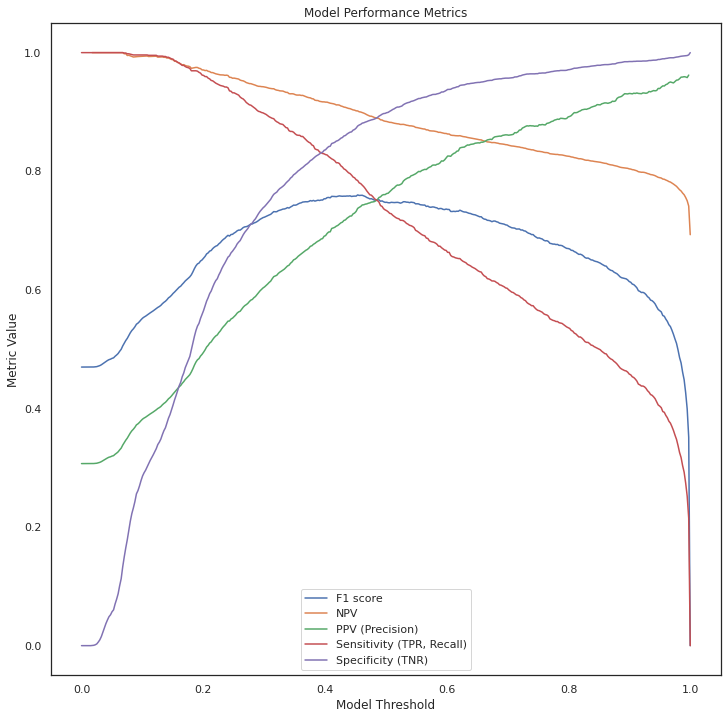

In [ ]:
# Rerun the predictions for the validation set
valid_preds = pd.Series(lrcv_clf.predict_proba(X_valid_std)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T

# Plot metrics including Precision, Recall, and Specificity against a range of thresholds
with np.errstate(divide='ignore', invalid='ignore'):

  ms = []
  thresholds = np.linspace(0,valid_preds.max(),400)
  for thresh in thresholds:
      res = {}
      prediction = valid_preds[:,1] > thresh

      accuracy = accuracy_score(y_valid,prediction)
      cm = confusion_matrix(y_valid,prediction)

      res['confusion_matrix'] = cm
      res['Accuracy'] = accuracy
      res['F1 score'] = f1_score(y_valid,prediction)
      res['FPR'] = cm[0,1]/(cm[0,:].sum()*1.0)
      res['FNR'] = cm[1,0]/(cm[1,:].sum()*1.0)
      res['Specificity (TNR)'] = cm[0,0]/(cm[0,:].sum()*1.0)
      res['Sensitivity (TPR, Recall)'] = cm[1,1]/(cm[1,:].sum()*1.0)
      res['PPV (Precision)'] = cm[1,1]/(cm[:,1].sum()*1.0)
      res['NPV'] = cm[0,0]/(cm[:,0].sum()*1.0)
      ms.append(res)
  ms_df = pd.DataFrame(ms)

fig, ax = plt.subplots(1,1,figsize=(12,12))
for metric in ['F1 score','NPV','PPV (Precision)','Sensitivity (TPR, Recall)','Specificity (TNR)']:
    plt.plot(thresholds,ms_df[metric],'-',label=metric)
ax.legend(loc=0)
ax.set_xlabel('Model Threshold')
ax.set_ylabel('Metric Value')
ax.set_title('Model Performance Metrics')
plt.show()

## ROC Curve for Testing Set

The AUC for the final model is 0.91 when using the test set, which is similar to what was attained on the validation set.

Test AUC:  0.9145501315380282


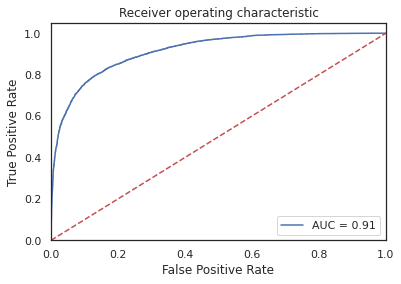

In [ ]:
# Evaluate performance using the 30% test set

valid_preds = pd.Series(lrcv_clf.predict_proba(X_valid_std)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T

test_preds = pd.Series(lrcv_clf.predict_proba(X_test_std)[:,1])
test_preds = test_preds.values
test_preds = np.array([test_preds,test_preds]).T

fpr, tpr, thresholds = metrics.roc_curve(y_test, test_preds[:, 1])
auc = metrics.auc(fpr, tpr)
print('Test AUC: ',str(auc))

# ROC 
roc_plot(y_test,test_preds)


## Overall Performance Metrics

We chose a prediction threshold of 0.5 based on the plot above. This should return similar Precision and Recall results.

In [ ]:
# Calculate metrics with 0.5 threshold

metrics_list = []

res = {}
prediction = test_preds[:,1] >= 0.5

accuracy = accuracy_score(y_test,prediction)
cm = confusion_matrix(y_test,prediction)

res['Confusion Matrix'] = cm
res['Accuracy'] = accuracy
res['F1 score'] = f1_score(y_test,prediction)
res['FPR'] = cm[0,1]/(cm[0,:].sum()*1.0)
res['FNR'] = cm[1,0]/(cm[1,:].sum()*1.0)
res['Specificity (TNR)'] = cm[0,0]/(cm[0,:].sum()*1.0)
res['Sensitivity (TPR, Recall)'] = cm[1,1]/(cm[1,:].sum()*1.0)
res['PPV (Precision)'] = cm[1,1]/(cm[:,1].sum()*1.0)
res['NPV'] = cm[0,0]/(cm[:,0].sum()*1.0)

metrics_list.append(res)

pd.DataFrame(metrics_list)


,Confusion Matrix,Accuracy,F1 score,FPR,FNR,Specificity (TNR),"Sensitivity (TPR, Recall)",PPV (Precision),NPV
0,"[[9468, 1055], [1099, 3378]]",0.8564,0.758249,0.100257,0.245477,0.899743,0.754523,0.762012,0.895997


## Performance within Subgroups

In [ ]:
# Add Predictions to test data
test_review = test.copy()
test_review['pred'] = list(test_preds[:,1])
test_review['pred_yn'] = np.where(test_review.pred >= 0.5, 1, 0)                                          

# test_review.head()

In [ ]:
# Calculate metrics at the patient-visit level
test_review['Accurate_YN'] = np.where((test_review.pred_yn == test_review.admit_yn),1,0)
test_review['TP'] = np.where((test_review.pred_yn == 1) & (test_review.admit_yn == 1),1,0)
test_review['FP'] = np.where((test_review.pred_yn == 1) & (test_review.admit_yn == 0),1,0)
test_review['FN'] = np.where((test_review.pred_yn == 0) & (test_review.admit_yn == 1),1,0)
test_review['TN'] = np.where((test_review.pred_yn == 0) & (test_review.admit_yn == 0),1,0)
# test_review.head()      

We subsequently calculate the metrics within each subgroup of interest, including race, ethnicity, language, gender, and insurance status.

In [ ]:
def auc_group(df):
    y_hat = df.pred
    y = df.admit_yn.values
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat)
    auc = metrics.auc(fpr, tpr)
    return auc

cols = ['race_category','ethnicity','lang','religion_category','gender','insurance_status']

all_groups_df = pd.DataFrame(columns=['Category','Subgroup','Observed Admission Rate','Predicted Admission Rate','Accuracy','AUC','PPV','Recall','FPR'])

for col in cols:
    rates = test_review.groupby(col).agg({'admit_yn':'mean',
                                          'pred_yn':'mean',
                                          'Accurate_YN':'mean',
                                          'TP':'sum',
                                          'FP':'sum',
                                          'FN':'sum',
                                          'TN':'sum'
                                      }).reset_index()
    
    auc = test_review.groupby(col).apply(auc_group).reset_index(name='AUC')
    
    metrics_df = auc.merge(rates, left_on=col, right_on=col)
    
    metrics_df['Category'] = col
    metrics_df['Subgroup'] = auc[col]
    metrics_df['PPV'] = metrics_df.TP/(metrics_df.TP + metrics_df.FP)
    metrics_df['Recall'] = metrics_df.TP/(metrics_df.TP + metrics_df.FN)
    metrics_df['FPR'] = metrics_df.FP/(metrics_df.FP + metrics_df.FN)

    metrics_df.rename(columns={'admit_yn':'Observed Admission Rate','pred_yn':'Predicted Admission Rate','Accurate_YN':'Accuracy'},inplace=True)

    metrics_df = metrics_df[['Category','Subgroup','Observed Admission Rate','Predicted Admission Rate','Accuracy','AUC','PPV','Recall','FPR']]
    all_groups_df = pd.concat([all_groups_df,metrics_df], ignore_index=True, axis=0)


The results below show similar AUCs for the ethnicity, language, and gender subgroups (all >= 0.90). There's slightly reduced performance for the patients in the Asian or Pacific Islander race category (AUC = 0.87), which could be due to that group having a smaller sample size (Asian patients represented 1.2% of the data compared to 27.9% for Black and 53.6% for White). Patients in this group were also more likely to be missing lab results and vitals data. Among all the subgroups, patients with an insurance status of self-pay had the poorest performance (AUC = 0.74). Only about 0.3% of patients were self-pay.

Another performance consideration involves the comparing the predicted rates of admission to the actual rates of admission within the subgroups. White patients were less likely to be admitted than predicted (when setting the threshold at 0.5), while all other racial categories were more likely to be admitted then predicted. This was particularly striking for American Indian or Alaska Native patients, among whom 21% were predicted compared to 36% actually admitted, and Asian and Pacific Islander patients, among whom 17% were predicted to be admitted when 26% were actually admitted.

In [ ]:
# Display Results
all_groups_df

,Category,Subgroup,Observed Admission Rate,Predicted Admission Rate,Accuracy,AUC,PPV,Recall,FPR
0,race_category,American Indian or Alaska Native,0.357143,0.214286,0.714286,0.933333,0.666667,0.400000,0.250000
1,race_category,Asian or Pacific Islander,0.257143,0.171429,0.845714,0.871282,0.800000,0.533333,0.222222
2,race_category,Black or African American,0.232922,0.228653,0.885674,0.922560,0.759336,0.745418,0.481328
3,race_category,Other,0.187988,0.172357,0.883998,0.912343,0.708831,0.649891,0.432624
4,race_category,Unknown,0.257310,0.181287,0.853801,0.908912,0.806452,0.568182,0.240000
5,race_category,White or Caucasian,0.368322,0.373577,0.833104,0.905466,0.769591,0.780571,0.515742
6,ethnicity,Hispanic or Latino,0.191700,0.169565,0.878261,0.902232,0.706294,0.624742,0.409091
7,ethnicity,Non-Hispanic,0.320819,0.321547,0.851687,0.914426,0.768244,0.769987,0.502455
8,ethnicity,Patient Refused,0.323529,0.323529,0.882353,0.924901,0.818182,0.818182,0.500000
9,ethnicity,Unknown,0.207792,0.246753,0.883117,0.953893,0.684211,0.812500,0.666667


Next, we evaluate the alternative logistic regression model that excludes the sensitive categories. We obtain a similar AUC of 0.913 with this model.

Test AUC:  0.9129259835677812


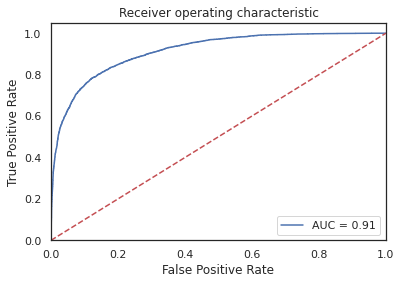

In [ ]:
# Evaluate performance using the 30% test set
test_preds = pd.Series(lrcv_alt.predict_proba(X_test_std[new_features])[:,1])
test_preds = test_preds.values
test_preds = np.array([test_preds,test_preds]).T

fpr, tpr, thresholds = metrics.roc_curve(y_test, test_preds[:, 1])
auc = metrics.auc(fpr, tpr)
print('Test AUC: ',str(auc))

# ROC 
roc_plot(y_test,test_preds)


In [ ]:
# Add Predictions to test data
test_review = test.copy()
test_review['pred'] = list(test_preds[:,1])
test_review['pred_yn'] = np.where(test_review.pred >= 0.5, 1, 0)

# Calculate metrics at the patient-visit level
test_review['Accurate_YN'] = np.where((test_review.pred_yn == test_review.admit_yn),1,0)
test_review['TP'] = np.where((test_review.pred_yn == 1) & (test_review.admit_yn == 1),1,0)
test_review['FP'] = np.where((test_review.pred_yn == 1) & (test_review.admit_yn == 0),1,0)
test_review['FN'] = np.where((test_review.pred_yn == 0) & (test_review.admit_yn == 1),1,0)
test_review['TN'] = np.where((test_review.pred_yn == 0) & (test_review.admit_yn == 0),1,0)      

In [ ]:
cols = ['race_category','ethnicity','lang','religion_category','gender','insurance_status']

all_groups_df = pd.DataFrame(columns=['Category','Subgroup','Observed Admission Rate','Predicted Admission Rate','Accuracy','AUC','PPV','Recall','FPR'])

for col in cols:
    rates = test_review.groupby(col).agg({'admit_yn':'mean',
                                          'pred_yn':'mean',
                                          'Accurate_YN':'mean',
                                          'TP':'sum',
                                          'FP':'sum',
                                          'FN':'sum',
                                          'TN':'sum'
                                      }).reset_index()
    
    auc = test_review.groupby(col).apply(auc_group).reset_index(name='AUC')
    
    metrics_df = auc.merge(rates, left_on=col, right_on=col)
    
    metrics_df['Category'] = col
    metrics_df['Subgroup'] = auc[col]
    metrics_df['PPV'] = metrics_df.TP/(metrics_df.TP + metrics_df.FP)
    metrics_df['Recall'] = metrics_df.TP/(metrics_df.TP + metrics_df.FN)
    metrics_df['FPR'] = metrics_df.FP/(metrics_df.FP + metrics_df.FN)

    metrics_df.rename(columns={'admit_yn':'Observed Admission Rate','pred_yn':'Predicted Admission Rate','Accurate_YN':'Accuracy'},inplace=True)

    metrics_df = metrics_df[['Category','Subgroup','Observed Admission Rate','Predicted Admission Rate','Accuracy','AUC','PPV','Recall','FPR']]
    all_groups_df = pd.concat([all_groups_df,metrics_df], ignore_index=True, axis=0)

Once again, we look at the performance specifically within subgroups. There did not seem to be much that has changed in terms of the AUC. The AUC for patients in the Asian or Pacific Islander subgroup was again 0.87 and for patients with an insurance status of self-pay was 0.74. 

The predicted admission rate for White patients decreased from 37.3% to 37.1% (still above the observed rate of 36.8%), while the predicted admission rate increased for American Indian or Alaska Native patients from 21.4% to 28.6% (though still lower than the observed rate of 35.7%). The predicted admission rate for Asian or Pacific Islander patients remained the same (17.1% predicted vs 25.7% observed).

In [ ]:
# Display Results
all_groups_df

,Category,Subgroup,Observed Admission Rate,Predicted Admission Rate,Accuracy,AUC,PPV,Recall,FPR
0,race_category,American Indian or Alaska Native,0.357143,0.285714,0.785714,0.911111,0.750000,0.600000,0.333333
1,race_category,Asian or Pacific Islander,0.257143,0.171429,0.845714,0.870256,0.800000,0.533333,0.222222
2,race_category,Black or African American,0.232922,0.228416,0.883539,0.920908,0.754933,0.740326,0.480652
3,race_category,Other,0.187988,0.176882,0.879473,0.907431,0.690698,0.649891,0.453925
4,race_category,Unknown,0.257310,0.181287,0.853801,0.908554,0.806452,0.568182,0.240000
5,race_category,White or Caucasian,0.368322,0.370824,0.832604,0.904849,0.770918,0.776155,0.507474
6,ethnicity,Hispanic or Latino,0.191700,0.173518,0.873518,0.897405,0.687927,0.622680,0.428125
7,ethnicity,Non-Hispanic,0.320819,0.319848,0.850797,0.913383,0.768277,0.765952,0.496746
8,ethnicity,Patient Refused,0.323529,0.323529,0.882353,0.924901,0.818182,0.818182,0.500000
9,ethnicity,Unknown,0.207792,0.246753,0.883117,0.950820,0.684211,0.812500,0.666667


# Discussion

We were able to successfully reproduce a model with adequate accuracy to predict admission from the ED with an AUC of 0.91. We compared the performance of different models including logistic regression, random forest, a gradient boosting classifier, and a feedforward neural network using a validation set. We ultimately selected the logistic regression model because of its increased interpretability. 

Although the model performed well on the test data (AUC = 0.91), there were some notable subgroup differences. White patients had higher predicted admission rates than were actually observed, while other racial categories were likely to be admitted than observed (35.7% vs 21.4% for American Indian and Alaska Native patients and 25.7% vs 17.1% for Asian and Pacific Islander patients). When we removed race, ethnicity, language, religion, and insurance status from the model, these differences were still not sufficiently addressed. One possible reason is that some of these subgroups were underrepresented in the sample. There were also different levels of missingness across subgroups.

## Limitations

There were several limitations to our analyses. Because the data was de-identified for privacy purposes, we were not able to include several features in our analysis. Geographic data could be useful for evaluating whether patients living closer to the ED are more likely to use it for non-emergent conditions. Geographic data could also be used to incorporate additional sociodemographic characteristics in the model evaluation (e.g., estimated household income, education level). The year of the visit was also removed from the de-identified data, so we could not evaluate performance over time.

Some of the data points were already categorized from raw values, such as ICD-10 diagnosis codes and medication class, which resulted in a loss of some specific information.

Although the full dataset included more than 560,000 ED visits, the authors reported there were only a little over 200,000 unique patients. Therefore, some patients were represented multiple times and, because they were de-identified (with no unique identifier), they may have appeared in both the training and validation/test sets. This potential lack of independence could have led to an overly optimistic accuracy score.

## Future Directions
For this project, we used a 50,000 record subset of the dataset. The authors of the original paper reported obtaining a comparable AUC from logistic regression when using 10% of their full training sample. In the future, we plan to oversample from certain subgroups and reevaluate the model's performance. However, this may also lead to larger issues related to having subjects with multiple visits and corresponding lack of independence among observations.

For this analysis, we only removed the most obvious problematic features from the model. Future analyses should explore the potential for bias by proxy. We observed significant association between race and ESI acuity level, which was a strong predictor for admission. While it is possible that patients within certain subgroups use the ED for less urgent conditions, the ESI acuity is not a completely objective measure. We plan to evaluate the model without the ESI acuity score. Even though it may turn out to be a necessary feature for an accurate prediction, it would still be important to examine the differences in predictive probabilities and observed outcomes across subgroups.

There are also additional steps we could take in the model building process. For example, although we ran PCA on our features, it did not seem to dramatically improve the performance of the models. In the future, we would like to experiment with other feature engineering techniques to further improve the selection of features.

Lastly, we would like to tune our deep neural net further to improve accuracy. We have been using a manual process to tune the number of layers and/or the number of neurons in each layer. However, using tools such as Amazon SageMaker to automatically tune the model to find the best hyperparameters can potentially increase the performance while saving time from the manual tuning process. Furthermore, incorporating other deep learning techniques such as reinforcement learning or recurrent neural network can potentially produce interesting results.

# Conclusion

We were able to develop a model with relatively high accuracy (AUC = 0.91) for predicting hospital admissions from the ED. We observed differences in performance across subgroups, such as lower predicted rates compared to observed among non-White patients. Developing models from this data without carefully considering how it could adversely impact certain groups could worsen health disparities. Although we attempted to resolve some of these differences in our project, additional work is necessary before this model should be implemented.

# References

Hong WS, Haimovich AD, Taylor RA. Predicting hospital admission at emergency department triage using machine learning. PLOS ONE 2018;13:e0201016. doi:10.1371/journal.pone.0201016

Schrader CD, Lewis LM. Racial Disparity in Emergency Department Triage. Journal of Emergency Medicine 2013;44:511–8. doi:10.1016/j.jemermed.2012.05.010
